# ARI5102 Assignment - Individual Project
##### Nathan Portelli
##### Year 2023/24

***Please ensure that 'dataset.csv' is placed in the same folder as this Notebook.***

# Importing Python Libraries

#### Required Packages

In [ ]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install scikit-learn-extra
# !pip install seaborn

In [1]:
import pandas as pd
import numpy as np

# For Task 3
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns  # For the barplot

# For Task 4
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples

import os
import warnings
from sklearn.exceptions import DataConversionWarning

#### Additional Setup

In [2]:
# To show all rows in the output
pd.set_option('display.max_rows', None)

In [3]:
scaler = MinMaxScaler()

# Importing Dataset

In [4]:
# Importing and loading the dataset into DataFrame
data = pd.read_csv("dataset.csv")

# Task 1

<a id='task_1'></a>

***To get a feel for the employed dataset, do some initial exploration and answer the following questions:***

## 1.1: How many questions exist in the survey?

<a id='task_1_1'></a>

The dataset header includes prefixes for each question's response options. For instance, `q3_1, q3_2, ... q3_10` represent possible answers for question `q3`. Since the suffixes identify specific options within a question, removing them from the header content would leave `q1, q2, ... q10`. Counting these unique prefixes gives the total number of questions in the survey.

In [5]:
# List of columns, each of which represent the options for each question
columns = data.columns

# Unique question prefixes
unique_questions = set([col.split('_')[0] for col in columns])
print("Unique Questions:", unique_questions)
# Total number of unique questions
print("Number of questions in the survey:", len(unique_questions))

Unique Questions: {'q6', 'q2', 'q8', 'q9', 'q4', 'q10', 'q3', 'q5', 'q7', 'q1'}
Number of questions in the survey: 10


## 1.2: How many respondents are in the survey?

Each row within the dataset represents a single unique respondent with their unique responses, apart from the first row which serves as a header that contains details on the content on each column. Therefore, counting the number of rows in the dataset except the first row provides the number of respondents.

As DataFrames include the header by default, it is not listed as part of the row count. Therefore, the `len()` function can be used without modification.

In [6]:
# Number of rows (excluding the header)
num_respondents = len(data) 

print("Number of respondents in the survey:", num_respondents)

Number of respondents in the survey: 2288


## 1.3: What are the different question types based on their selection options?

<a id='task_1_3'></a>

The possible question types based on the respondents' selections are divided into two categories, depending on whether the question allows for:
1. Single or multiple responses
2. Single or multiple options

To determine the single/multiple selection type for each question, the dataset's columns are iterated through, splitting each column name to extract the question prefix, as done in [Task 1.1](#task_1_1). It is then checked whether the prefix already exists in the `selection_types` dictionary. If it does, the selection type is evaluated to see if it is already marked as `Multiple`; if not, it updates the selection type to `Multiple`. If the question prefix is not found in the dictionary, it is assumed to be a single-selection question and is marked accordingly.

Next, the question type is identified by iterating through the dataset columns again. For each column, the question prefix is extracted and the `question_types` dictionary is checked to see if it already exists within it. If not, an entry for the question prefix is created. Then, the type of responses (single or multiple) is determined by summing responses across columns with the same prefix. If the maximum sum of responses is more than '1', the question is marked as allowing multiple responses; otherwise, it is marked as allowing single responses.

This information is then combined for each question. The result for "responses" is omitted when the question only allows for a single option, as it is not possible for a question with one option to have multiple responses.

In [7]:
print("Question Types:")

question_types = {}  # Question types for all questions
selection_types = {}  # Determine single/multiple selection type for each question

# Checking if single or multiple options
for col in data.columns:
    question_prefix = col.split('_')[0]
    # If prefix is not in dictionary, assume a single-option question
    if question_prefix not in selection_types:
        selection_types[question_prefix] = 'Single'
    else:
        selection_types[question_prefix] = 'Multiple'

# Checking if single or multiple responses
for col in data.columns:
    question_prefix = col.split('_')[0]
    if question_prefix not in question_types:
        question_types[question_prefix] = set()
    
    # Determine if single or multiple-response questions
    question_columns = [col for col in data.columns if col.startswith(question_prefix)]
    
    responses_sum = data[question_columns].sum(axis=1)
    responses_max = responses_sum.max()
    if responses_max == 1:
        question_types[question_prefix].add("Single")
    else: 
        question_types[question_prefix].add("Multiple")

# Print combined options and response types
for question, q_types in question_types.items():
    q_type_str = " ".join(q_types)
    print(f"{question}: {selection_types[question]} options", end = "")
    if selection_types[question] == 'Multiple':
        print(f" & {q_type_str} responses")
    else:
        print("")

Question Types:
q1: Single options
q2: Single options
q3: Multiple options & Single responses
q4: Multiple options & Single responses
q5: Multiple options & Single responses
q6: Multiple options & Multiple responses
q7: Multiple options & Multiple responses
q8: Multiple options & Multiple responses
q9: Multiple options & Multiple responses
q10: Multiple options & Multiple responses


# Task 2

***If you were asked to build a model for a question in the dataset, using the rest of the questions as explanatory variables:***

## 2.1: Which performance measures would you use?

<a id='task_2_1'></a>

When building a model for questions in the dataset, the choice of performance measures hinges upon the nature of the target variable and the specific objectives of the analysis. As shown in [Task 1](#task_1), the dataset comprises questions that fall under different classification categories, each demanding different types of evaluation metrics.

**Question 1 & 2**
- These questions present *Binary Classification Problems*, with only two possible outcomes [[1]](#references). For these types of questions, measures such as Accuracy, Precision, Recall, F1-score, and the Area under the ROC curve (AUC-ROC) may be used to assess the performance of the model [[1, 3]](#references).

**Questions 3, 4 & 5**
- On the other hand, questions involving multiple potential outputs, but only one selection allowed, can be described as *Multi-Class Classification Problems* with Mutually Exclusive Classes, as they entail multiple potential outputs, yet only one output can be selected [[1, 3]](#references). In this case, similar performance measures as questions 1 and 2 could be used, being accuracy, precision, recall, F1-Score and confusion matrices. 
- Additionally, the Micro F1-score, which aggregates F1-scores across all classes using micro-averaging, provides a balanced assessment of the model's performance, especially when dealing with class imbalance [[2]](#references). 
- Besides Accuracy, which provides an overall measure of how correct the model's predictions are, Balanced Accuracy may also be used, which gives equal weight to each class and is therefore insensitive to class distribution [[2]](#references), making it useful if the survey responses are found to be balanced.

**Questions 6 through 10**
- Finally, questions allowing for the selection of multiple outputs simultaneously fall under *Multi-Label Classification Problems* [[1, 4]](#references). Here, evaluation metrics such as Hamming Loss, precision at k, recall at k, F1-score at k, and subset accuracy become instrumental in gauging the model's predictive capabilities.

## 2.2: Does the selection of the performance metric depend on the type of question?

Yes, as shown in [Task 2.1](#task_2_1), the selection of the performance metric depends on the type of question being addressed. Different types of questions present distinct characteristics, necessitating the use of specific performance metrics that are most suitable for evaluating the model’s effectiveness. Particularly;

**Binary Classification** *(Question 1 and 2)*:
- In these problems, where there are only two possible outcomes, metrics such as accuracy, precision, recall, F1-score, and the [AUC-ROC](#abbreviations) are commonly used. These metrics provide insights into the model's ability to correctly classify instances into one of the two classes, taking into account True Positives (TP) represent correctly classified positive instances, True Negatives (TN) denote correctly classified negative instances, False Positives (FP) indicate negative instances incorrectly classified as positive, and False Negatives (FN) signify positive instances incorrectly classified as negative [[1, 3]](#references).

**Multi-Class Classification** *(Question 3 to 5)*:
- In the case of Multi-Class Classification Problems, where there are multiple possible outputs but only one can be selected, many metrics could be utilised, such as Accuracy, Balanced Accuracy (especially if the results of the question are unbalanced), F1-scores (particularly Micro-Average), and also Confusion Matrices. These metrics enable the assessment of the model's performance across multiple classes, providing insights into its ability to distinguish between different categories [[1, 2]](#references).

**Multi-Label Classification** *(Question 6 to 10)*:
- For Multi-Label Classification problems, where multiple outputs can be simultaneously selected, performance metrics such as Hamming Loss, F1-score (both Micro-Average and Macro-Average), and Subset Accuracy are often employed. These metrics are designed to evaluate the model's ability to accurately predict multiple labels for each instance, considering the complexities of multi-label prediction tasks [[4]](#references).

Each performance metric has its advantages and disadvantages, and therefore the choice of usage depends on the specific characteristics of the type, context, and properties of the question being modelled.

These metrics are defined as follows;

**Accuracy**
- The proportion of correct predictions made by the model. It is calculated as `(TP + TN) / Total Samples`. It is simple to understand and interpret, and useful when all classes are balanced and misclassifications have equal weight. However, it can be misleading in imbalanced questions, as the model might prioritise predicting the majority class [[2, 3]](#references).

**Balanced Accuracy**
- An alternative accuracy measure specifically designed for multi-class classification problems with imbalanced datasets. It calculates the average recall for each class in a multi-class setting, and then takes the mean. Unlike the traditional accuracy metric, it provides a more robust measure of accuracy in imbalanced datasets, as it focuses on the model's ability to identify [TP](#abbreviations) for all classes. However, it does not directly consider precision [[2, 3]](#references).

**Precision**
- The proportion of true positive predictions from all positive predictions made by the model. It's calculated as `TP / (TP + FP)`. It emphasises the model's ability to avoid FP errors and is particularly useful when the cost of incorrectly predicting a positive case is high. But it not be ideal if missing [TP](#abbreviations) cases is a major concern [[2, 3]](#references).

**Recall**
- The proportion of actual positive cases that are correctly identified by the model. It is calculated as `TP / (TP + FN)`. This emphasises the model's ability to capture all relevant positive cases, and, opposite of Prevision, is useful when missing true positive cases is a major concern. Inversely, it may not be ideal if [FP](#abbreviations) errors are costly [[2, 3]](#references).

**F1-Score**
- Combining the competing Precision and Recall metrics, the F1-Score presents the harmonic mean of these metrics. It's calculated as `2 * (Precision * Recall) / (Precision + Recall)`, offering a nuanced evaluation of the model's capability to classify each class accurately. Unlike Accuracy, which evaluates overall correctness, the F1-Score focuses on the harmonic mean of precision and recall, making it suitable for scenarios where both metrics are equally important [[2, 3]](#references).

- *Micro-Average F1-Score*
    - Calculates the F1-score by treating the entire dataset as one single multi-class classification problem. It considers all [TP](#abbreviations)s, [FP](#abbreviations)s, [TN](#abbreviations)s, and [FN](#abbreviations)s across all classes. This is useful when all classes are balanced or when the overall performance across all classes is the primary concern, but it can be misleading with imbalanced datasets, where the F1-score might be dominated by the performance on the majority class [[2]](#references).

- *Macro-Average F1-Score*
    - Calculates the average F1-score for each individual class in the multi-class classification problem. It first computes the F1-score for each class independently, then averages them. This provides a more balanced view of the model's performance across all classes, and is especially helpful in imbalanced datasets. But it may not be ideal if the importance of different classes varies significantly [[2]](#references).

**Hamming Loss**
- Measures the average proportion of incorrect labels predicted by the model for a multi-label classification task. This is calculated as `Total Number of Incorrect Labels/Total Number of Labels` across all samples. It is usually well-suited for Multi-Label Classification Problems since each instance can have multiple correct labels. It also provides a clear understanding of the model's overall prediction accuracy for each label. However, it does not distinguish between different types of errors (missing correct labels vs. predicting incorrect labels) [[4]](#references).

# Task 3

<a id='task_3'></a>

***Consider the fifth question (q5) as a response variable and build a predictive model using some or all other questions as explanatory variables.***

## 3.1.1: Implement a suitable algorithm for this task.

<a id='task_3_1_1'></a>

### Preliminary Steps

#### Extracting Explanatory and Response Variables

In [8]:
explanatory = data.drop(columns=['q5_1', 'q5_2', 'q5_3', 'q5_4', 'q5_5', 'q5_6', 'q5_7', 'q5_8', 'q5_9', 'q5_10'])
response = data[['q5_1', 'q5_2', 'q5_3', 'q5_4', 'q5_5', 'q5_6', 'q5_7', 'q5_8', 'q5_9', 'q5_10']]

print("Explanatory Variables:\n", explanatory.columns.tolist())
print("Response Variables:\n", response.columns.tolist())

Explanatory Variables:
 ['q1_1', 'q2_1', 'q3_1', 'q3_2', 'q3_3', 'q3_4', 'q3_5', 'q3_6', 'q3_7', 'q3_8', 'q3_9', 'q3_10', 'q4_1', 'q4_2', 'q4_3', 'q4_4', 'q4_5', 'q4_6', 'q4_7', 'q4_8', 'q4_9', 'q4_10', 'q6_1', 'q6_2', 'q6_3', 'q6_4', 'q6_5', 'q6_6', 'q6_7', 'q6_8', 'q6_9', 'q6_10', 'q7_1', 'q7_2', 'q7_3', 'q7_4', 'q7_5', 'q7_6', 'q7_7', 'q7_8', 'q7_9', 'q7_10', 'q8_1', 'q8_2', 'q8_3', 'q8_4', 'q8_5', 'q8_6', 'q8_7', 'q8_8', 'q8_9', 'q8_10', 'q9_1', 'q9_2', 'q9_3', 'q9_4', 'q9_5', 'q9_6', 'q9_7', 'q9_8', 'q9_9', 'q9_10', 'q10_1', 'q10_2', 'q10_3', 'q10_4', 'q10_5', 'q10_6', 'q10_7', 'q10_8', 'q10_9', 'q10_10']
Response Variables:
 ['q5_1', 'q5_2', 'q5_3', 'q5_4', 'q5_5', 'q5_6', 'q5_7', 'q5_8', 'q5_9', 'q5_10']


#### Missing and Incorrect Responses

##### Missing Values

In [9]:
# Amount of missing values per column in explanatory, grouped by question
missing_explanatory_grouped = explanatory.filter(like='q').isnull().sum().groupby(lambda x: x.split('_')[0]).sum()

# Amount of missing values per column in response, grouped by question
missing_response_grouped = response.filter(like='q').isnull().sum().groupby(lambda x: x.split('_')[0]).sum()

print("Missing Values in Explanatory Data (Grouped by Question):")
print(missing_explanatory_grouped)

print("\nMissing Values in Response Data (Grouped by Question):")
print(missing_response_grouped)

Missing Values in Explanatory Data (Grouped by Question):
q1         0
q10        0
q2         0
q3         0
q4         0
q6      8110
q7         0
q8     12550
q9         0
dtype: int64

Missing Values in Response Data (Grouped by Question):
q5    0
dtype: int64


The following is additional information on the missing data:

Missing Values Summary:
q1_1         0
q2_1         0
q3_1         0
q3_2         0
q3_3         0
q3_4         0
q3_5         0
q3_6         0
q3_7         0
q3_8         0
q3_9         0
q3_10        0
q4_1         0
q4_2         0
q4_3         0
q4_4         0
q4_5         0
q4_6         0
q4_7         0
q4_8         0
q4_9         0
q4_10        0
q5_1         0
q5_2         0
q5_3         0
q5_4         0
q5_5         0
q5_6         0
q5_7         0
q5_8         0
q5_9         0
q5_10        0
q6_1       811
q6_2       811
q6_3       811
q6_4       811
q6_5       811
q6_6       811
q6_7       811
q6_8       811
q6_9       811
q6_10      811
q7_1         0
q7_2         0
q7_3         0
q7_4         0
q7_5         0
q7_6         0
q7_7         0
q7_8         0
q7_9         0
q7_10        0
q8_1      1255
q8_2      1255
q8_3      1255
q8_4      1255
q8_5      1255
q8_6      1255
q8_7      1255
q8_8      1255
q8_9      1255
q8_10     1255
q9_1         0
q9_2         0
q9_3         0
q

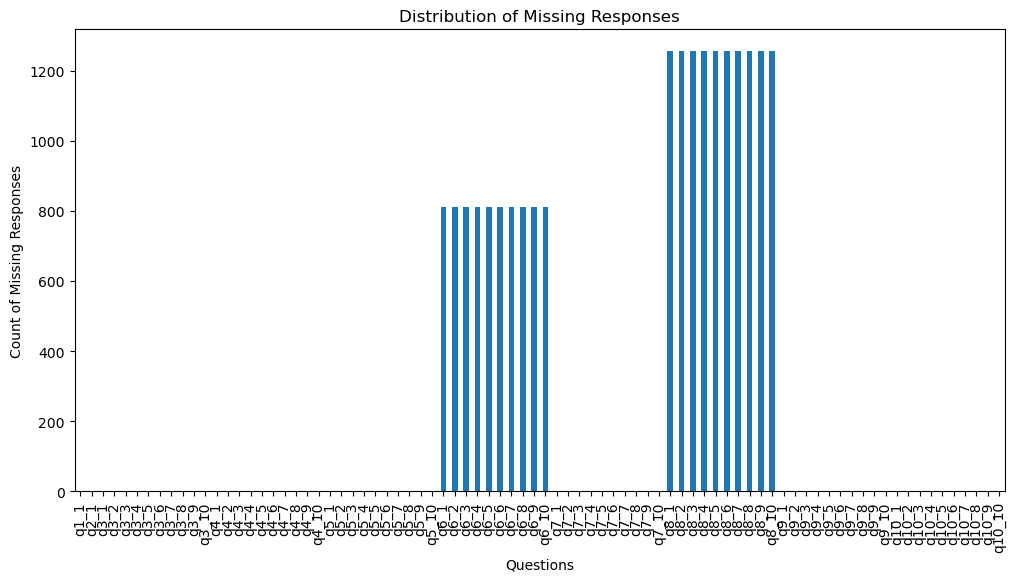

In [10]:
# Missingness patterns
print("Missing Values Summary:")
print(data.isnull().sum())  # Count of missing values per column

# Missingness by row

# Checking if all the responses are missing per question 
# by taking a single response option and comparing with total missing values
missing_q6_count = data[data['q6_1'].isnull()].shape[0]
missing_q8_count = data[data['q8_1'].isnull()].shape[0]
total_records = data.shape[0]

print(f"\nMissing responses (%) in q6: {missing_q6_count} ({missing_q6_count / total_records:.2f})")
print(f"Missing responses (%) in q8: {missing_q8_count} ({missing_q8_count / total_records:.2f})")

# Plot: Missingness distribution
missing = data.isnull().sum()

plt.figure(figsize=(12, 6))

# Plot the missingness distribution
missing.plot(kind='bar')
plt.xlabel('Questions')
plt.ylabel('Count of Missing Responses')
plt.title('Distribution of Missing Responses')
plt.xticks(rotation=90)
plt.show()


##### Incorrect Values

In [11]:
# Checking if there are any values that do *not* correspond to 0, 1, or NaN (known and accepted values in the dataset)
found_invalid = False
for col in explanatory.columns:
    for value in explanatory[col]:
        if pd.isna(value):
            continue
        if value not in [0, 1]:
            print(f"{col}: {value}")
            found_invalid = True

if not found_invalid:
    print("All values are either 0, 1, or NaN")

All values are either 0, 1, or NaN


##### Analysis of Missing Values

Although all the available data is of the correct format, a number of records have missing values, particularly from questions 6 and 8.

Deleting of the missing data is one solution;
1. **List-wise deletion**; whereby the entire incomplete records is deleted. This however would disregard valuable data gathered from the rest of the questions, and may not be feasible due to the amount of missing responses. It also has been shown to introduce bias when performing data analysis [[5, 6]](#references).
2. **Column-wise deletion**; which removes whole columns with the missing values. However this would mean that question 6 and 8 would be completely omitted. Since the importance of these questions is not known, this is not a viable option.

With 2289 total records, and 811 missing records from `q6`, and 1255 missing records from `q8`, deletion is also not ideal due to the amount of missing records, as it would result in either 2 of the 10 questions, or more than half of the responses, being deleted. When the missing data is not random, deletion would also introduce a very high bias [[6]](#references).

An alternative to deletion is imputation [[6, 7, 8]](#references). There are various methods of imputation, the most common of which are;

3. **Simple Imputation**; which would replace missing values with the mean (average), median (middle value), or the mode (most frequent value) of the corresponding column [[6, 7, 8]](#references). 
    - Mean Imputation is suitable for continuous, normally distributed data with no significant outliers [[7, 8]](#references).
    - Median Imputation is a good choice for continuous data that is skewed or has outliers [[8]](#references).
    - Mode Imputation is primarily used for categorical data.
    
4. **K-Nearest Neighbors (KNN)**; where missing values are imputed based on similar rows in the data [[7]](#references). 

5. **Regression Imputation**; involves the use of regression models to predict missing values based on the relationships between variables in the dataset. This technique is popular as it can provide accurate estimates for missing data points, especially when there are strong correlations between variables [[6]](#references).

6. **Hot-Deck Imputation**; is a method that matches missing values with similar values from other observations in the dataset. It involves selecting a "donor" observation with complete data that closely matches the observation with missing values. This technique helps to preserve the structure of the data and can be effective in handling missing values, especially in survey data analysis [[6]](#references).


Although this might introduce bias since the missingness does not seem to be random, imputation seems to be the best available method to ensure that none of the available data is outright deleted [[7]](#references).

In order to decide on which method to use, the missingness pattern being faced needs to be determined. Particularly, whether the missing responses are; 

1. **Missing Completely At Random (MCAR)**, where the missing values occur entirely by chance and are unrelated to the variable itself or any other variables in the data [[6, 7]](#references).

If the missing values occur for a reason that is connected to the variable itself or other factors in the data, it would not simply be random chance. In that scenario, the data could be;

2. **Missing At Random (MAR)**, where the missingness is not completely random, but it can be explained by other observed information in the data. In this scenario, it might be possible to statistically account for it using techniques like weighting cases [[6, 7]](#references).
   
3. **Missing Not At Random (MNAR)**, which has missing values related to the variable itself, and the reason for missingness is not captured in the available data. This can result in the data being significantly biased, which would be amplified if used with Imputation techniques [[6]](#references).

Since only `q6` and `q8` have missing data, it means that missingness cannot be of [MCAR](#abbreviations) type.

However, as domain knowledge on the subject of the questions is missing, it cannot yet be directly determined whether the type of missingness in `q6` and `q8` is [MAR](#abbreviations) or [MNAR](#abbreviations).

##### Correlation Between Missing Responses

In [12]:
# Counting the missing values per question in the explanatory variables
missing_explanatory = explanatory.isnull().sum()

# Displaying missing values in explanatory data
print("Missing Values in Explanatory Data (Grouped by Question):")
print(missing_explanatory)

# Analysing patterns in missing data for q6 and q8
missing_q6 = explanatory[['q6_1', 'q6_2', 'q6_3', 'q6_4', 'q6_5', 'q6_6', 'q6_7', 'q6_8', 'q6_9', 'q6_10']].isnull().sum(axis=1)
missing_q8 = explanatory[['q8_1', 'q8_2', 'q8_3', 'q8_4', 'q8_5', 'q8_6', 'q8_7', 'q8_8', 'q8_9', 'q8_10']].isnull().sum(axis=1)

# Checking the correlation between missingness of q6 and q8
correlation = np.corrcoef(missing_q6, missing_q8)[0, 1]
print("\nCorrelation between missingness of q6 and q8:", correlation)

Missing Values in Explanatory Data (Grouped by Question):
q1_1         0
q2_1         0
q3_1         0
q3_2         0
q3_3         0
q3_4         0
q3_5         0
q3_6         0
q3_7         0
q3_8         0
q3_9         0
q3_10        0
q4_1         0
q4_2         0
q4_3         0
q4_4         0
q4_5         0
q4_6         0
q4_7         0
q4_8         0
q4_9         0
q4_10        0
q6_1       811
q6_2       811
q6_3       811
q6_4       811
q6_5       811
q6_6       811
q6_7       811
q6_8       811
q6_9       811
q6_10      811
q7_1         0
q7_2         0
q7_3         0
q7_4         0
q7_5         0
q7_6         0
q7_7         0
q7_8         0
q7_9         0
q7_10        0
q8_1      1255
q8_2      1255
q8_3      1255
q8_4      1255
q8_5      1255
q8_6      1255
q8_7      1255
q8_8      1255
q8_9      1255
q8_10     1255
q9_1         0
q9_2         0
q9_3         0
q9_4         0
q9_5         0
q9_6         0
q9_7         0
q9_8         0
q9_9         0
q9_10        0
q10_1       

Given the weak correlation between the missingness of questions 6 and 8, it's less likely that their missingness patterns are strongly related to each other. This suggests that the missingness may be more random or at least not strongly associated between these two variables. 

##### Responses of the rest of the questions when q6 and q8 are not picked

In [13]:
# Filtering q6 or q8 
data_q6 = data.dropna(subset=['q6_1', 'q6_2', 'q6_3', 'q6_4', 'q6_5', 'q6_6', 'q6_7', 'q6_8', 'q6_9', 'q6_10'])
data_q8 = data.dropna(subset=['q8_1', 'q8_2', 'q8_3', 'q8_4', 'q8_5', 'q8_6', 'q8_7', 'q8_8', 'q8_9', 'q8_10'])

# Remaining questions when q6 or q8 are not picked
def extract_remaining_questions(data):
    remaining_questions = data[['q1_1', 'q2_1', 'q3_1', 'q3_2', 'q3_3', 'q3_4', 'q3_5', 'q3_6', 'q3_7', 'q3_8',
                                'q3_9', 'q3_10', 'q4_1', 'q4_2', 'q4_3', 'q4_4', 'q4_5', 'q4_6', 'q4_7', 'q4_8',
                                'q4_9', 'q4_10', 'q5_1', 'q5_2', 'q5_3', 'q5_4', 'q5_5', 'q5_6', 'q5_7', 'q5_8',
                                'q5_9', 'q5_10', 'q7_1', 'q7_2', 'q7_3', 'q7_4', 'q7_5', 'q7_6', 'q7_7', 'q7_8',
                                'q7_9', 'q7_10', 'q9_1', 'q9_2', 'q9_3', 'q9_4', 'q9_5', 'q9_6', 'q9_7', 'q9_8',
                                'q9_9', 'q9_10', 'q10_1', 'q10_2', 'q10_3', 'q10_4', 'q10_5', 'q10_6', 'q10_7',
                                'q10_8', 'q10_9', 'q10_10']]
    return remaining_questions

data_remaining_q6 = extract_remaining_questions(data_q6)
data_remaining_q8 = extract_remaining_questions(data_q8)

# Distribution of responses
response_distribution_q6 = data_remaining_q6.apply(pd.Series.value_counts).fillna(0)
response_distribution_q8 = data_remaining_q8.apply(pd.Series.value_counts).fillna(0)

print("Response Distribution when q6 is not picked:")
print(response_distribution_q6)

print("Response Distribution when q8 is not picked:")
print(response_distribution_q8)


Response Distribution when q6 is not picked:
       q1_1  q2_1  q3_1  q3_2  q3_3  q3_4  q3_5  q3_6  q3_7  q3_8  ...  q10_1  \
0.0     0.0   804  1215  1439  1308  1339  1388  1257  1293  1384  ...   1300   
1.0  1477.0   673   262    38   169   138    89   220   184    93  ...    177   

     q10_2  q10_3  q10_4  q10_5  q10_6  q10_7  q10_8  q10_9  q10_10  
0.0   1221    955   1174    826   1066    809   1073    646    1314  
1.0    256    522    303    651    411    668    404    831     163  

[2 rows x 62 columns]
Response Distribution when q8 is not picked:
     q1_1    q2_1  q3_1  q3_2  q3_3  q3_4  q3_5  q3_6  q3_7  q3_8  ...  q10_1  \
0.0   360     0.0   792   963   975  1010   928   914   848   943  ...    787   
1.0   673  1033.0   241    70    58    23   105   119   185    90  ...    246   

     q10_2  q10_3  q10_4  q10_5  q10_6  q10_7  q10_8  q10_9  q10_10  
0.0    958    773    564    390    513    815    966    546     941  
1.0     75    260    469    643    520    218    

One can see that when the response for `q1` is '0', q6 is ignored. Similarly, when `q2` is set to '0', `q8` is ignored. Therefore, the missingness of these questions can be explained by the response of `q1` and `q2`.

This means that the missingness of the data can be explained by other observed information, hence is categorised as **Missing at Random (MAR)**.

Since the responses for `q1` and `q2` completely explain the lack of response for `q6` and `q8` respectively, it can be assumed that positive respondants for `q1` and `q2` were guided to not provide a response for `q6` and `q8`. Since the nature of missing values is now understood, no method of deletion or imputation should be used as this would result in unnecessary loss of data or bias.

Instead, a new state will be introduced for `q6` and `q8` (`q6_nr` and `q8_nr`), which would be set to '1' when the data is missing, with the rest of the options `q6_1 ... q6_10` and `q8_1 ... q8_10` being set to '0'.

In [14]:
# Setting q6_nr to 1 when q1 is 0
explanatory['q6_nr'] = 0
explanatory.loc[explanatory['q1_1'] == 0, 'q6_nr'] = 1

# Setting q8_nr to 1 when q2 is 0
explanatory['q8_nr'] = 0
explanatory.loc[explanatory['q2_1'] == 0, 'q8_nr'] = 1

# Setting q6_1 to q6_10 and q8_1 to q8_10 to 0 when q1 and q2 are 0
q6_columns = [f'q6_{i}' for i in range(1, 11)]
q8_columns = [f'q8_{i}' for i in range(1, 11)]
 
explanatory.loc[explanatory['q1_1'] == 0, q6_columns] = 0
explanatory.loc[explanatory['q2_1'] == 0, q8_columns] = 0

#### Outliers

In [15]:
threshold = 1.5

# IQR for each feature
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers for each feature
outliers = ((data < (Q1 - threshold * IQR)) | (data > (Q3 + threshold * IQR))).sum()

# Counting the total number of outliers
total_outliers = outliers.sum()

print("Total number of outliers:", total_outliers)
print("Outliers per feature:")
print(outliers)

Total number of outliers: 12905
Outliers per feature:
q1_1        0
q2_1        0
q3_1      337
q3_2      110
q3_3      248
q3_4      174
q3_5      193
q3_6      247
q3_7      344
q3_8      155
q3_9      240
q3_10     240
q4_1      226
q4_2      285
q4_3      225
q4_4       76
q4_5      333
q4_6      186
q4_7      328
q4_8      199
q4_9      245
q4_10     185
q5_1      228
q5_2      189
q5_3      266
q5_4      366
q5_5      228
q5_6      154
q5_7      186
q5_8      230
q5_9       80
q5_10     361
q6_1        0
q6_2        0
q6_3       71
q6_4      275
q6_5        0
q6_6      192
q6_7        0
q6_8        0
q6_9        0
q6_10       0
q7_1        0
q7_2        0
q7_3        0
q7_4        0
q7_5      383
q7_6        0
q7_7        0
q7_8        0
q7_9        0
q7_10       0
q8_1      232
q8_2        0
q8_3      133
q8_4        0
q8_5      247
q8_6        0
q8_7        0
q8_8      123
q8_9        0
q8_10       0
q9_1        0
q9_2        0
q9_3      344
q9_4      250
q9_5        0
q9_6    

#### Data Imbalance

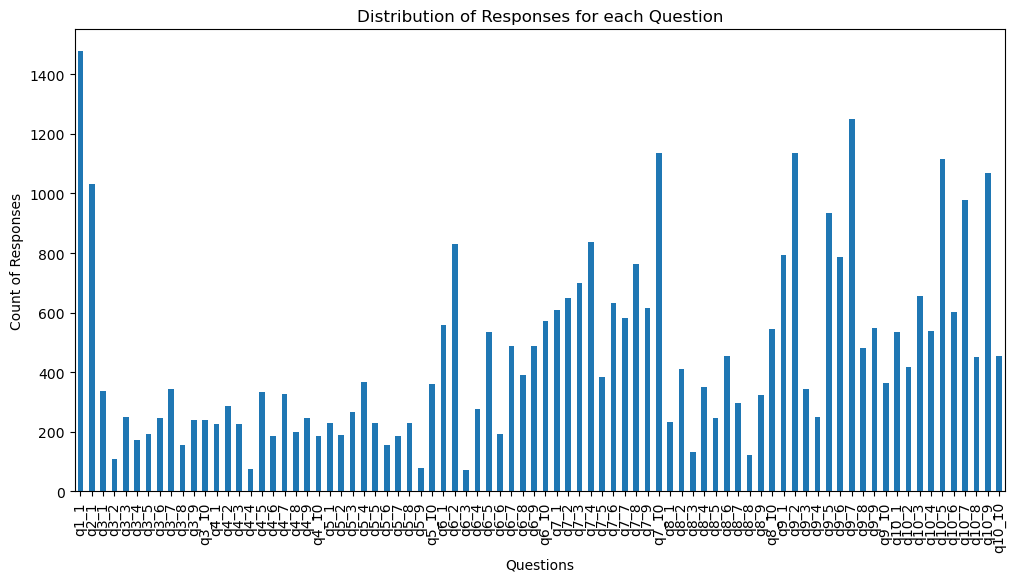

Distribution of Responses for each Question:
q1_1      1477.0
q2_1      1033.0
q3_1       337.0
q3_2       110.0
q3_3       248.0
q3_4       174.0
q3_5       193.0
q3_6       247.0
q3_7       344.0
q3_8       155.0
q3_9       240.0
q3_10      240.0
q4_1       226.0
q4_2       285.0
q4_3       225.0
q4_4        76.0
q4_5       333.0
q4_6       186.0
q4_7       328.0
q4_8       199.0
q4_9       245.0
q4_10      185.0
q5_1       228.0
q5_2       189.0
q5_3       266.0
q5_4       366.0
q5_5       228.0
q5_6       154.0
q5_7       186.0
q5_8       230.0
q5_9        80.0
q5_10      361.0
q6_1       559.0
q6_2       830.0
q6_3        71.0
q6_4       275.0
q6_5       536.0
q6_6       192.0
q6_7       489.0
q6_8       390.0
q6_9       488.0
q6_10      573.0
q7_1       608.0
q7_2       648.0
q7_3       700.0
q7_4       837.0
q7_5       383.0
q7_6       633.0
q7_7       582.0
q7_8       764.0
q7_9       614.0
q7_10     1135.0
q8_1       232.0
q8_2       411.0
q8_3       133.0
q8_4       351.0
q8_

In [16]:
# Distribution of responses for each question
distribution = data.sum()

plt.figure(figsize=(12, 6))

distribution.plot(kind='bar')
plt.xlabel('Questions')
plt.ylabel('Count of Responses')
plt.title('Distribution of Responses for each Question')
plt.xticks(rotation=90)
plt.show()

print("Distribution of Responses for each Question:")
print(distribution)

#### Training and Test Splitting

In [17]:
# Splitting the dataset into training and testing (70/30)
X_train, X_test, y_train, y_test = train_test_split(explanatory, response, test_size=0.3, random_state=42)
train = pd.concat([X_train, y_train], axis=1, join='inner')
test = pd.concat([X_test, y_test], axis=1, join='inner')

#### Hyperparameter Grids

In [18]:
# Hyperparameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Hyperparameter grid for Neural Network
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

### Implementation

There are numerous models that can fit the requirements of this dataset application. The Decision Tree (DT) and Neural Network (NN) models were selected for comparison. 

The model which achieves the highest evaluation metrics will be used for future tasks.

#### Decision Tree

The Decision Tree algorithm was included due to its traditional and simple yet effective method of handling both linear and non-linear relationships [[9, 10]](#references). Moreover, [DT](#abbreviations)s are robust to outliers [[9]](#references), which have been identified in our dataset, and also allow for higher interpretability and a better understanding of the model's predictions [[9, 10]](#references).

In [19]:
# Hyperparameter Tuning
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
dt_grid_search.fit(X_train, y_train)
best_dt_model = dt_grid_search.best_estimator_
print(f"Best parameters: {dt_grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [21]:
# Best parameters taken from above
best_dt_params = {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}

# Training the Decision Tree model with the best parameters
dt_model = DecisionTreeClassifier(**best_dt_params)
dt_model.fit(X_train, y_train)

# Making predictions on testing data
dt_y_pred = dt_model.predict(X_test)

#### Neural Network

Neural Networks (NNs) can handle more complex relationships in data [[11, 12]](#references). Since the aim is to predict survey responses based on the diverse features, [NN](#abbreviations)s offer a promising solution. 

Unlike more traditional algorithms, [NN](#abbreviations)s can effectively capture intricate patterns found in high-dimensional datasets [[12]](#references), which is useful in our case due to the numerous features and records. 

Additionally, [NN](#abbreviations)s can autonomously learn hierarchical data representations [[13]](#references), which could be advantageous when handling complex decision boundaries. 

In [22]:
# Normalising the explanatory variables
standard_scaler = StandardScaler()
explanatory_normalised = standard_scaler.fit_transform(explanatory)

# Splitting the dataset into normalised training and testing sets
X_train_normalised, X_test_normalised, y_train_normalised, y_test_normalised = train_test_split(explanatory_normalised, response, test_size=0.3, random_state=42)

In [23]:
# Hyperparameter Tuning
mlp_grid_search = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), mlp_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
mlp_grid_search.fit(X_train_normalised, y_train)
best_mlp_model = mlp_grid_search.best_estimator_
print(f"Best parameters: {mlp_grid_search.best_params_}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [24]:
# Neural Network Implementation with Best Parameters
best_mlp_params = {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'alpha': 0.01, 'learning_rate': 'constant', 'solver': 'adam',}

mlp_model = MLPClassifier(max_iter=1000, random_state=42, **best_mlp_params)
mlp_model.fit(X_train_normalised, y_train_normalised)

mlp_y_pred = mlp_model.predict(X_test_normalised)

## 3.1.2: Evaluate the implemented model using the metrics you proposed in Task 2

### Decision Tree

In [25]:
accuracy = accuracy_score(y_test, dt_y_pred)
precision = precision_score(y_test, dt_y_pred, average='weighted')
recall = recall_score(y_test, dt_y_pred, average='weighted')
f1 = f1_score(y_test, dt_y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.14119359534206696
Precision: 0.1526724351209888
Recall: 0.14119359534206696
F1-Score: 0.14463628455533104


### Neural Network

In [26]:
accuracy = accuracy_score(y_test_normalised, mlp_y_pred)
precision = precision_score(y_test_normalised, mlp_y_pred, average='weighted')
recall = recall_score(y_test_normalised, mlp_y_pred, average='weighted')
f1 = f1_score(y_test_normalised, mlp_y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.049490538573508006
Precision: 0.12821944679293595
Recall: 0.06550218340611354
F1-Score: 0.0827268346036132


Based on these evaluations, the Decision Tree model outperformed Neural Network model in terms of accuracy, precision, recall, and F1-score. 

Therefore, going forward, the Decision Tree will be used and further evaluated.

## 3.1.3: Interpret the trained model (if possible) and the obtained results.

### Decision Tree

#### Tree Structure Visualisation

Due to the logic of a decision tree being transparent and generally easy to follow [[9, 10]](#references), the interpretation of the model is indeed possible.

Visualising the tree structure provides one of the simplest methods of viewing the decision rules. Each node represents a decision based on a feature, and the branches represent the outcome of the decision.

*For the sake of readability, the figure was limited to 3 nodes.*

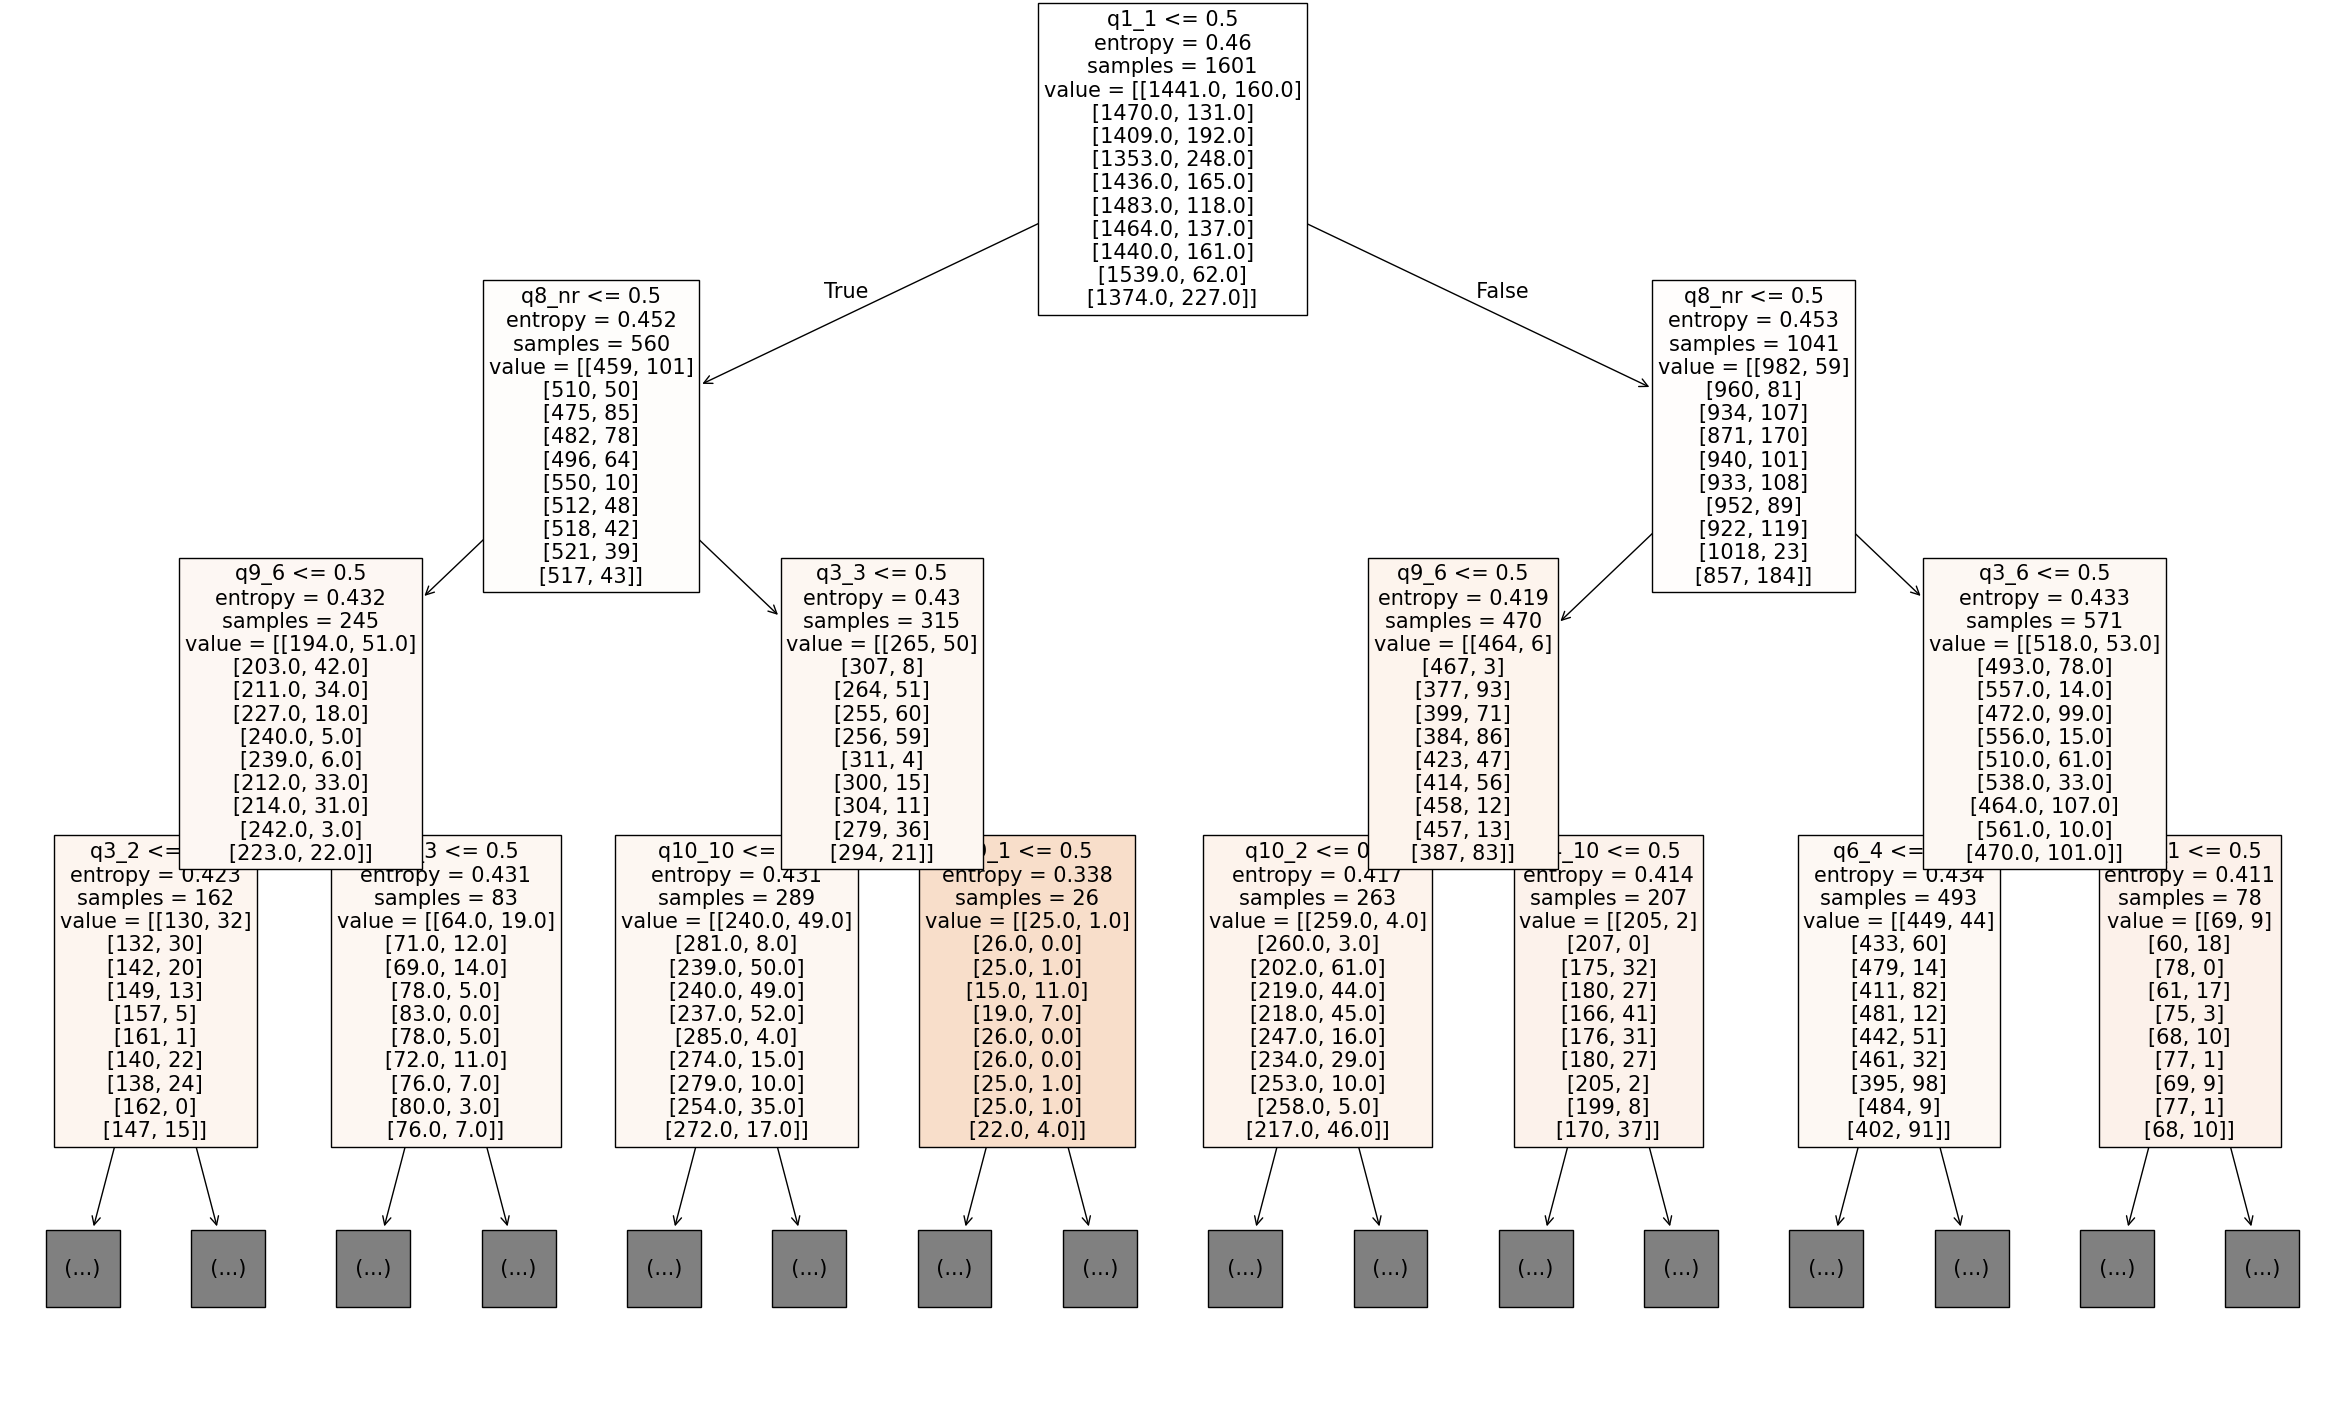

In [27]:
# Plotting the Decision Tree

plt.figure(figsize=(30, 18))
tree.plot_tree(dt_model, max_depth=3, feature_names=list(X_train.columns), class_names=y_train.columns, 
               filled=True, fontsize=15)
plt.show()

To provide better interpretation of the given [DT](#abbreviations) plot and results, it is best to provide a brief explaination on how [DT](#abbreviations)s work.

**Root Node**
- The topmost node in a [DT](#abbreviations) node, which represents the entire dataset. It is split into subsets based on values of selected features [[9, 13]](#references). In the figure, one can see that the root node was set to `q1_1`.

**Branches**
- As each node represents a decision point, branches, representing the possible outcomes of a decision [[9, 13]](#references), are used to extend from it to its child nodes, a subnode with additional child nodes, or a leaf node. As discussed in [Task 3.1.1](#task_3_1_1), the value of the root node `q1_1`, which also has the value of `q6_nr` dependent on it, branching out depending on whether `q1_1` is '0' or '1'.

**Leaf Nodes**
- These are the terminal/last nodes of a [DT](#abbreviations) where the final  prediction is made [[9, 13]](#references). In classification problems, each leaf node typically represents a specific class label [[9]](#references). Due to size limitations, the leaf nodes are not visible in the figure above, however based on the results of Hypertuning, the maximum depth a leaf node is set to 30.

**Subsets**
- The process of building a [DT](#abbreviations) involves recursively partitioning the dataset into further subsets based on the values of features. This partitioning aims to maximise the homogeneity of the subsets concerning the target variable [[9]](#references).

**Splitting Rules**
- Used to determine how to divide the dataset at each node. Examples of common rules include `Gini` and `Entropy` [[9, 13]](#references). For this implementation, `Entropy`, which measures the amount of uncertainty/disorder, was determined through hypertuning to reach a higher accuracy.

#### Feature Importance

Delving further into the splits created by the model, [DT](#abbreviations)s inherently provide feature importance scores based on how often a feature is used to split the data, and how much it improves the model's performance.

Ranging from '0' to '1', the higher the score, the more important a feature is for the model's predictions, with a '0' meaning that the feature was not used by the model.

Feature: q1_1, Importance: 0.017450338985106926
Feature: q2_1, Importance: 0.0
Feature: q3_1, Importance: 0.01199398842005736
Feature: q3_2, Importance: 0.004623719645928826
Feature: q3_3, Importance: 0.008908981288672279
Feature: q3_4, Importance: 0.007256631397040129
Feature: q3_5, Importance: 0.009925334911322452
Feature: q3_6, Importance: 0.006501883319959444
Feature: q3_7, Importance: 0.00994251088623309
Feature: q3_8, Importance: 0.00992008914051497
Feature: q3_9, Importance: 0.014548603762034812
Feature: q3_10, Importance: 0.004221023294995048
Feature: q4_1, Importance: 0.011417132460126756
Feature: q4_2, Importance: 0.013730861526712127
Feature: q4_3, Importance: 0.010449342312735768
Feature: q4_4, Importance: 0.005423925450791967
Feature: q4_5, Importance: 0.009423626670566836
Feature: q4_6, Importance: 0.006130421159525468
Feature: q4_7, Importance: 0.01503202298966776
Feature: q4_8, Importance: 0.007803395179015293
Feature: q4_9, Importance: 0.01484160477897574
Feature: q4_1

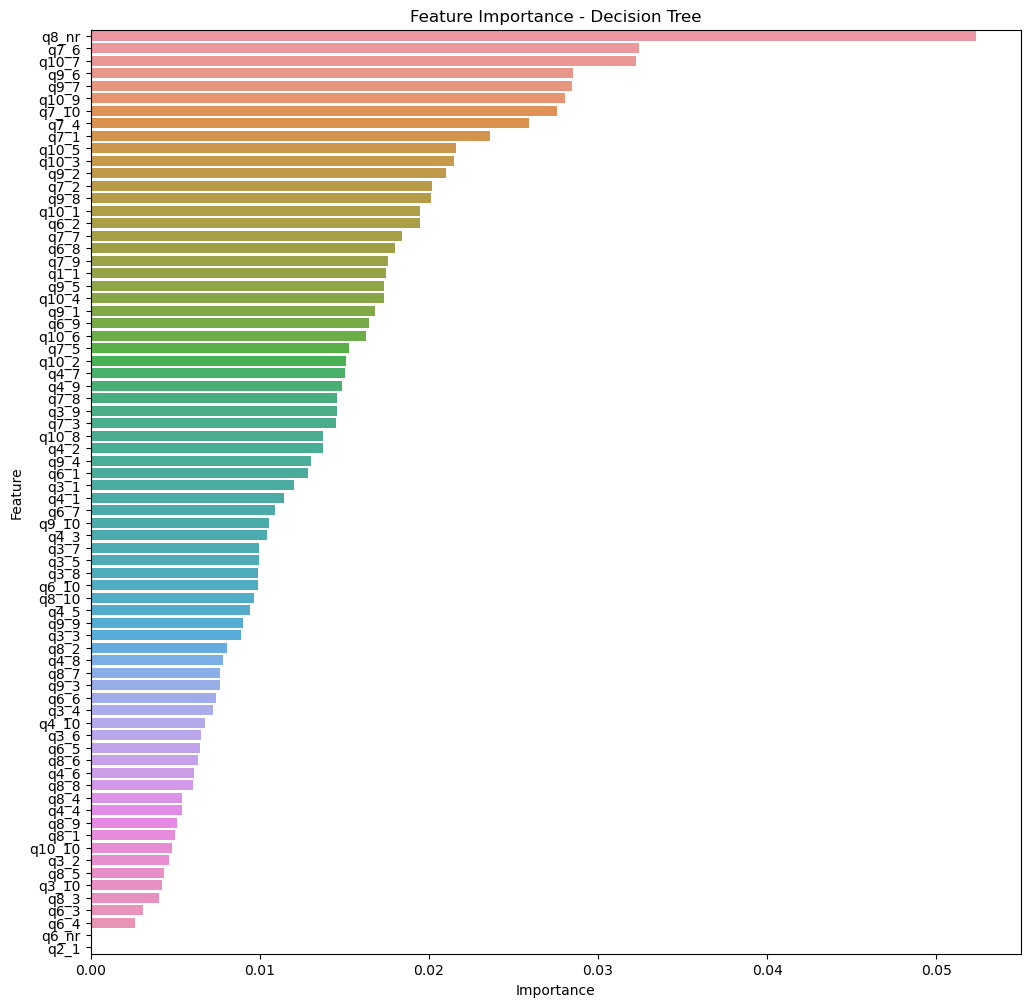

In [28]:
# Feature importance per explanatory variable
for feature, importance in zip(explanatory.columns.tolist(), dt_model.feature_importances_):
    print(f'Feature: {feature}, Importance: {importance}')

# Visualisation
importance = pd.DataFrame({'Feature': explanatory.columns.tolist(), 'Importance': dt_model.feature_importances_})
importance = importance.sort_values(by='Importance', ascending=False)  # Sorting by importance

plt.figure(figsize=(12, 12))
sns.barplot(x='Importance', y='Feature', data=importance)
plt.title('Feature Importance - Decision Tree')
plt.show()

- *High Importance Features*:  Features with higher importance scores, such a `q8_nr`, `q7_6` and `q10_7` are the most influential in the modl's decisions, havinge the greatest impact on the final predictionss.

- *Zero Importance Features*: `q6_nr` and `q2_1` have an importance score of '0'. This means that these features were not used at all by the [DT](#abbreviations) when making splits. This is likely due to the fact that both features are duplicates, with `q6_nr` being a duplicate of `q1_1`, and `q2_1` being a duplicate of `q8_nr`.

#### Confusion Matrix

In a confusion matrix, the rows correspond to the true/actual labels and the columns correspond to the predicted labels.

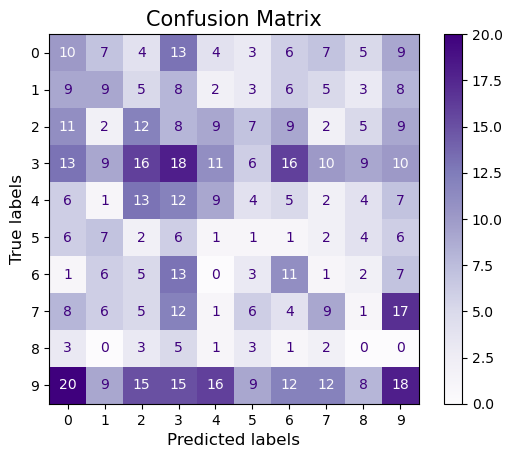

In [29]:
cm = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(dt_y_pred).argmax(axis=1))
labels = [str(i) for i in range(10)]

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

cm_display.plot(cmap='Purples', values_format='g')
plt.xlabel('Predicted labels', fontsize=12)
plt.ylabel('True labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

- *True Positives*: The values from the top-left to the bottom-right are elements where the predicted and true labels match, hence where correctly predicted.

- *False Positives*: For every other instance, the label does not match the true label, and therefore the prediction generated is incorrect. The most common misclassifications across multiple predicted classes are shown to be classes 3 and 9.

This matrix shows that the model still has a high misclassification rate, with notable confusions between classes.

___Let’s assume that the options of the fifth question (q5) are semantically ordered, e.g. q5 corresponds to the question “How much do you like this photograph from 1-10?” with options q5_1=1, q5_2=2 and so on.___

## 3.2.1: Implement a predictive model incorporating this new piece of information.

### Modification of Response Variable

In [30]:
response_modified = response.copy()

for i in range(1, 11):
    col_name = f'q5_{i}'
    response_modified[col_name] = response_modified[col_name].apply(lambda x: i if x == 1 else x)

# Sum of all columns q5_1 ... q5_10
response_modified['q5'] = response_modified.sum(axis=1)
# Only keeping the new q5 column, deleting q5_1 ... q5_10
response_modified = response_modified[['q5']]
    
response_modified.head()

,q5
0,5.0
1,8.0
2,7.0
3,1.0
4,1.0


### Implementation

In [31]:
# Splitting the dataset into training and testing (70/30)
X_train_modified, X_test_modified, y_train_modified, y_test_modified = train_test_split(explanatory, response_modified, test_size=0.3, random_state=42)
train_modified = pd.concat([X_train_modified, y_train_modified], axis=1, join='inner')
test_modified = pd.concat([X_test_modified, y_test_modified], axis=1, join='inner')

In [32]:
# Hyperparameter Tuning
dt_modified_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
dt_modified_grid_search.fit(X_train_modified, y_train_modified)
best_dt_modified_model = dt_modified_grid_search.best_estimator_
print("Best parameters for Decision Tree with Modified Response Variable:", dt_modified_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Decision Tree with Modified Response Variable: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [33]:
# Best parameters taken from above
best_dt_modified_params = {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}

# Training the Decision Tree model with the best parameters
dt_modified_model = DecisionTreeClassifier(**best_dt_modified_params)
dt_modified_model.fit(X_train_modified, y_train_modified)

# Making predictions on testing data
dt_modified_y_pred = dt_modified_model.predict(X_test_modified)

## 3.2.2: Select appropriate metrics to evaluate the performance of the model in this scenario.

Since the response variable `q5_1 ... q5_10` are now semantically ordered, the classification problem has now shifted from a Multi-Class Classification Problems (as shown in [Task 2.1](#task_2_1)) into an Ordinal Classification Problem.

Ordinal Classification Problems, unlike Multi-Class Classification, takes into account the ordered nature of the classes [[15]](#references), and therefore requires evaluation metrics that respect this ordering.

According to the results of [[15]](#references), the Mean Absolute Error (MAE) and Mean Squared Error (MSE) emerged as the most suitable metrics for ordinal classification, despite not being ordinal by design. [MSE](#abbreviations) is preferred in scenarios where the severity of the errors is of critical concern, since it penalises such errors more severely. On the other hand, [MAE](#abbreviations) is advantageous in situations where there is lower tolerance for even small errors, since it treats all errors uniformally [[15]](#references). Since critical information on the nature of the data is missing, both metrics will be used.

Additionally, the weighted kappa index will be incorporated as an evaluation metric. The weighted kappa was recommended for ordinal classification problems by [[16, 17]](#references) as it measures inter-rater agreement while respecting the order of classes. Optimising the weighted kappa index as both an evaluation function and a loss function during model training has been shown to improve classification performance, particularly when there is an ordinal relationship between the output classes.

In [34]:
mae = mean_absolute_error(y_test_modified, dt_modified_y_pred)
print("Mean Absolute Error (MAE):", mae)

mse = mean_squared_error(y_test_modified, dt_modified_y_pred)
print("Mean Squared Error (MSE):", mse)

weighted_kappa = cohen_kappa_score(y_test_modified, dt_modified_y_pred, weights='quadratic')
print("Weighted Kappa:", weighted_kappa)

Mean Absolute Error (MAE): 3.3842794759825328
Mean Squared Error (MSE): 18.295487627365357
Weighted Kappa: 0.0170859361118032


Overall, these metrics indicate that the model's performance might not be satisfactory for the task at hand. In particular, the results from the Weighted Kappa indicate very slight agreement between the model's predictions and the actual values. This suggests that the model's performance is not significantly better than random chance.

# Task 4

<a id='task_4'></a>

___In this task, you should identify similar respondents. Specifically, you should do the following:___

## 4.1: Create groups of “like-minded”/similar respondents by proposing and implementing one or more suitable algorithms.

<a id='task_4_1'></a>

Before analysing the clusters or implementing any clustering algorithms, a simple approach of encoding `q3` and `q4` as single columns, similarly to what was done to `q5`, would allow for the amount of dimensions present to be reduced without any Dimensionality Reduction techniques being necessary. This will be done specifically on `q3` and `q4` since these are the only Multi-Class Classification Problems with multiple possible outputs but only one possible selection at a time, as shown in [Task 1.3](task_1_3).

In [35]:
explanatory_modified = explanatory.copy()

# q3
for i in range(1, 11):
    col_name = f'q3_{i}'
    explanatory_modified[col_name] = explanatory_modified[col_name].apply(lambda x: i if x == 1 else x)
# q4
for i in range(1, 11):
    col_name = f'q4_{i}'
    explanatory_modified[col_name] = explanatory_modified[col_name].apply(lambda x: i if x == 1 else x)

# Summing columns q3_1 ... q3_10
explanatory_modified['q3'] = explanatory_modified[[f'q3_{i}' for i in range(1, 11)]].sum(axis=1)
# Only keeping the new q3 column, deleting q3_1 ... q3_10
explanatory_modified.drop(columns=[f'q3_{i}' for i in range(1, 11)], inplace=True)

# Summing columns q4_1 ... q4_10
explanatory_modified['q4'] = explanatory_modified[[f'q4_{i}' for i in range(1, 11)]].sum(axis=1)
# Only keeping the new q4 column, deleting q4_1 ... q4_10
explanatory_modified.drop(columns=[f'q4_{i}' for i in range(1, 11)], inplace=True)

explanatory_modified.head()

,q1_1,q2_1,q6_1,q6_2,q6_3,q6_4,q6_5,q6_6,q6_7,q6_8,...,q10_5,q10_6,q10_7,q10_8,q10_9,q10_10,q6_nr,q8_nr,q3,q4
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0,0,8.0,2.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0,1,4.0,3.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,7.0,5.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0,6.0,6.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1,1,6.0,5.0


Several clustering algorithms can be used to group similar respondents together. For this task, the following will be used;

- *K-Means*: A simple and efficient algorithm, particularly when dealing with quantitative variables. It partitions the data into `K` clusters by minimising the within-cluster variance. While simple to implement and is well suitable for large datasets or scenarios where clusters are spherical, it is sensitive to initial cluster centroids and requires the number of clusters to be specified in advance [[18, 19]](#references).

- *K-Medoids*: A variation of K-Means that uses medoids (representative points) instead of centroids. It works well with categorical variables and is more robust against outliers. This method is particularly suitable when dealing with mixed data types, both of which are present in the given dataset. However, it is more computationally intensive compared to K-Means, also requires the number of clusters to be specified in advance, and is sensitive to the choice of distance metric [[18, 19]](#references).

In [36]:
# For use by K-Means and K-Medoids separately
explanatory_kmeans = explanatory_modified.copy()
explanatory_kmedoids = explanatory.copy()  # Methods used require binary data

explanatory_kmeans_normalised = explanatory_modified.copy()
explanatory_kmedoids_normalised = explanatory.copy()

### K-Means

The Elbow Method, a technique used to determine the optimal number of clusters (`K`) in K-Means clustering, is implemented in order to visualise the intertia for different values of `K`.

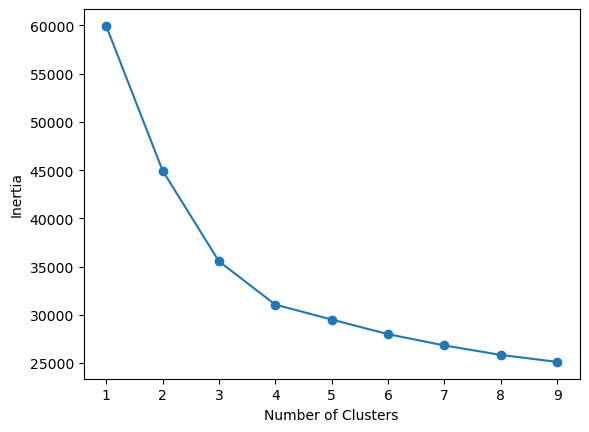

In [37]:
os.environ['LOKY_MAX_CPU_COUNT'] = '2'  # To silence potential CPU warning

def elbow_method(data):
    means = []
    inertias = []

    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    plt.plot(means, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

# Created as function to avoid a memory leak
elbow_method(explanatory_kmeans)

It appears that the “Elbow Point,” where the inertia levels off and further cluster additions do not significantly enhance the model’s performance, occurs at `4`.

In [38]:
# Fitting the means classifier
kmeans = KMeans(n_clusters=4, n_init="auto", random_state=0)
kmeans.fit(explanatory_kmeans)

KMeans(n_clusters=4, random_state=0)

In [39]:
explanatory_kmeans['kmeans_labels'] = kmeans.labels_
explanatory_kmeans.head()

,q1_1,q2_1,q6_1,q6_2,q6_3,q6_4,q6_5,q6_6,q6_7,q6_8,...,q10_6,q10_7,q10_8,q10_9,q10_10,q6_nr,q8_nr,q3,q4,kmeans_labels
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0,0,8.0,2.0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0,1,4.0,3.0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,7.0,5.0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,6.0,6.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1,1,6.0,5.0,0


#### Cluster Validation

##### Cluster Centroid Analysis

This analysis shows the average value for each feature within each cluster. These centroids can be interpreted as the "average respondent" for every cluster, which therefore provides the defining characteristics of the group [[19]](#references).

In [40]:
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=explanatory_kmeans.columns[:-1])
print(cluster_centroids)

       q1_1      q2_1      q6_1      q6_2      q6_3      q6_4      q6_5  \
0  0.553090  0.440571  0.244057  0.326466  0.025357  0.087163  0.163233   
1  0.608949  0.490272  0.237354  0.313230  0.031128  0.122568  0.196498   
2  0.726050  0.433613  0.285714  0.435294  0.035294  0.129412  0.263866   
3  0.698905  0.447080  0.206204  0.372263  0.032847  0.145985  0.319343   

       q6_6      q6_7      q6_8  ...     q10_5     q10_6     q10_7     q10_8  \
0  0.080824  0.161648  0.185420  ...  0.508716  0.288431  0.427892  0.152139   
1  0.058366  0.202335  0.173152  ...  0.478599  0.266537  0.410506  0.196498   
2  0.112605  0.243697  0.181513  ...  0.475630  0.243697  0.435294  0.200000   
3  0.080292  0.251825  0.138686  ...  0.485401  0.253650  0.434307  0.246350   

      q10_9    q10_10     q6_nr     q8_nr        q3        q4  
0  0.423138  0.261490  0.446910  0.559429  7.942948  2.933439  
1  0.470817  0.175097  0.391051  0.509728  2.832685  3.091440  
2  0.499160  0.213445  0.273950

In order for `q3` and `q4` to not have more influence than the other values, as shown above, these values will be normalised. 

This is primarily done to ensure that all features contribute equally to the clustering process, thereby potentially improving cluster quality and interpretability.

##### Normalisation

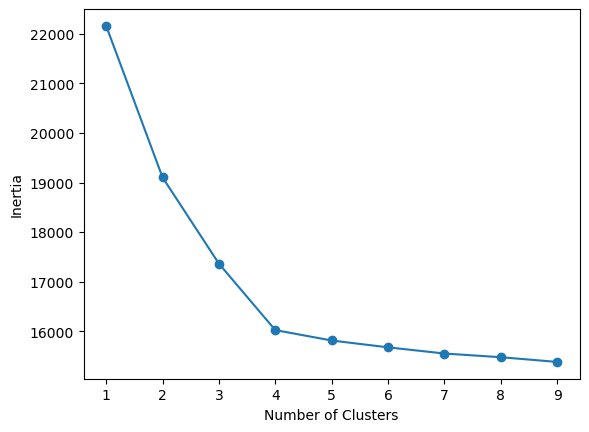

In [41]:
explanatory_kmeans_normalised[['q3', 'q4']] = scaler.fit_transform(explanatory_kmeans_normalised[['q3', 'q4']])

def elbow_method(data):
    means = []
    inertias = []

    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)
        
    plt.plot(means, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

# Created as function to avoid a memory leak
elbow_method(explanatory_kmeans_normalised)

In [42]:
# Fitting the means classifier

# n_cluster remains set to 4 to allow for better comparison.
kmeans_normalised = KMeans(n_clusters=4, n_init="auto", random_state=0)
kmeans_normalised.fit(explanatory_kmeans_normalised)

KMeans(n_clusters=4, random_state=0)

In [43]:
explanatory_kmeans_normalised['kmeans_labels'] = kmeans_normalised.labels_
explanatory_kmeans_normalised.head()

,q1_1,q2_1,q6_1,q6_2,q6_3,q6_4,q6_5,q6_6,q6_7,q6_8,...,q10_6,q10_7,q10_8,q10_9,q10_10,q6_nr,q8_nr,q3,q4,kmeans_labels
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0,0,0.777778,0.111111,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0,1,0.333333,0.222222,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,0,0.666667,0.444444,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0.555556,0.555556,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1,1,0.555556,0.444444,3


##### Cluster Centroid Analysis

In [44]:
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=explanatory_kmeans_normalised.columns[:-1])
print(cluster_centroids)

       q1_1      q2_1      q6_1      q6_2      q6_3      q6_4      q6_5  \
0  0.553090  0.440571  0.244057  0.326466  0.025357  0.087163  0.163233   
1  0.608949  0.490272  0.237354  0.313230  0.031128  0.122568  0.196498   
2  0.726050  0.433613  0.285714  0.435294  0.035294  0.129412  0.263866   
3  0.698905  0.447080  0.206204  0.372263  0.032847  0.145985  0.319343   

       q6_6      q6_7      q6_8  ...     q10_5     q10_6     q10_7     q10_8  \
0  0.080824  0.161648  0.185420  ...  0.508716  0.288431  0.427892  0.152139   
1  0.058366  0.202335  0.173152  ...  0.478599  0.266537  0.410506  0.196498   
2  0.112605  0.243697  0.181513  ...  0.475630  0.243697  0.435294  0.200000   
3  0.080292  0.251825  0.138686  ...  0.485401  0.253650  0.434307  0.246350   

      q10_9    q10_10     q6_nr     q8_nr        q3        q4  
0  0.423138  0.261490  0.446910  0.559429  7.942948  2.933439  
1  0.470817  0.175097  0.391051  0.509728  2.832685  3.091440  
2  0.499160  0.213445  0.273950

With `q3` and `q4` normalised, other values, such as those related to `q1`, `q6` and `q8` show significant reduction in influence, altering the representation of centroids.

#### Cluster Size

In [45]:
# Non-Normalised
cluster_size = explanatory_kmeans['kmeans_labels'].value_counts().sort_index()
print(cluster_size)

kmeans_labels
0    631
1    514
2    595
3    548
Name: count, dtype: int64


In [46]:
# Normalised
cluster_size_normalised = explanatory_kmeans_normalised['kmeans_labels'].value_counts().sort_index()
print(cluster_size_normalised)

kmeans_labels
0    673
1    804
2    360
3    451
Name: count, dtype: int64


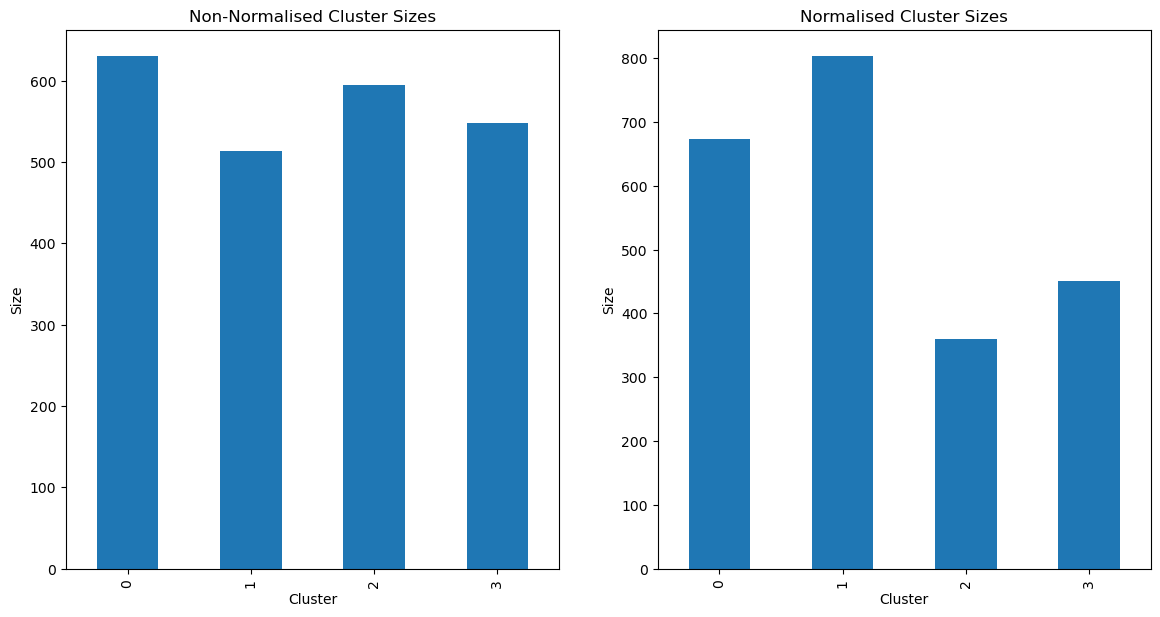

In [47]:
# Plotting the cluster sizes
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

cluster_size.plot(kind='bar', ax=ax[0], title='Non-Normalised Cluster Sizes')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Size')

cluster_size_normalised.plot(kind='bar', ax=ax[1], title='Normalised Cluster Sizes')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Size')

plt.show()

### K-Medoids

***Metrics***: Given the nature of the data, which includes both single and multiple selection questions with binary responses, a distance metric that effectively handles binary or categorical data is most appropriate. Therefore, the **Jaccard distance** metric, which measures the dissimilarity between binary vectors, was chosen.

***Method***: Partitioning Around Medoids (PAM) is the standard method for the K-Medoids algorithm, which iteratively refines the medoid selection through the swapping of a medoid with a non-medoid, and then computing the cost of the clustering. This process continues until no more improvements can be achieved, or until reaching the maximum number of iterations (`max_iter`) is reached. This method was chosen over Clustering Large Applications (Clara) method as [PAM](#abbreviations) is generally preferred with smaller datasets such as ours due to its comprehensive approach, and computational efficiency.

Using the same methods as K-Means, including a comparison of non-normalised and normalised data, the following is produced;

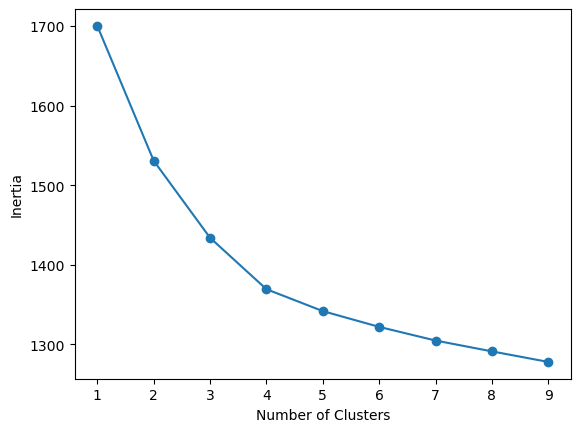

In [48]:
# Ignoring conversion warnings (created due to data formatting)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn_extra.cluster._k_medoids')
warnings.filterwarnings("ignore", category=DataConversionWarning, module='sklearn.metrics.pairwise')

def elbow_method(data):    
    means = []
    inertias = []

    for k in range(1, 10):
        kmedoids = KMedoids(n_clusters=k, metric='jaccard', method='pam', max_iter=500, random_state=1)
        kmedoids.fit(data)
        means.append(k)
        inertias.append(kmedoids.inertia_)
        
    plt.plot(means, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

# Created as function to avoid a memory leak
elbow_method(explanatory_kmedoids)

In [49]:
# Non-Normalised
kmedoids = KMedoids(n_clusters=4, random_state=0, metric='jaccard', method='pam', max_iter=500)
kmedoids.fit(explanatory_kmedoids)
explanatory_kmedoids['kmedoids_labels'] = kmedoids.labels_

In [50]:
explanatory_kmedoids.head()

,q1_1,q2_1,q3_1,q3_2,q3_3,q3_4,q3_5,q3_6,q3_7,q3_8,...,q10_4,q10_5,q10_6,q10_7,q10_8,q10_9,q10_10,q6_nr,q8_nr,kmedoids_labels
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0,3
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,1,0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,3
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,2


In [51]:
explanatory_kmedoids_normalised.head()

,q1_1,q2_1,q3_1,q3_2,q3_3,q3_4,q3_5,q3_6,q3_7,q3_8,...,q10_3,q10_4,q10_5,q10_6,q10_7,q10_8,q10_9,q10_10,q6_nr,q8_nr
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,1
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1


In [52]:
# Normalised
# n_clusters set to 4 to allow for better comparison
kmedoids_normalised = KMedoids(n_clusters=4, random_state=0, metric='jaccard', method='pam', max_iter=500)
kmedoids_normalised.fit(explanatory_kmeans_normalised)
explanatory_kmedoids_normalised['kmedoids_labels'] = kmedoids_normalised.labels_

In [53]:
explanatory_kmedoids_normalised.head()

,q1_1,q2_1,q3_1,q3_2,q3_3,q3_4,q3_5,q3_6,q3_7,q3_8,...,q10_4,q10_5,q10_6,q10_7,q10_8,q10_9,q10_10,q6_nr,q8_nr,kmedoids_labels
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0,0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0,1,2
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,3


#### Cluster Validation

##### Cluster Centroid Analysis

In [54]:
# Non-Normalised
cluster_centroids = pd.DataFrame(kmedoids.cluster_centers_, columns=explanatory_kmedoids.columns[:-1])
print(cluster_centroids)

   q1_1  q2_1  q3_1  q3_2  q3_3  q3_4  q3_5  q3_6  q3_7  q3_8  ...  q10_3  \
0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    1.0   
1   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
3   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   q10_4  q10_5  q10_6  q10_7  q10_8  q10_9  q10_10  q6_nr  q8_nr  
0    0.0    0.0    0.0    1.0    1.0    0.0     0.0    0.0    1.0  
1    1.0    1.0    1.0    0.0    0.0    0.0     0.0    1.0    0.0  
2    0.0    1.0    0.0    1.0    0.0    1.0     1.0    1.0    1.0  
3    0.0    1.0    1.0    0.0    0.0    1.0     0.0    0.0    0.0  

[4 rows x 74 columns]


In [55]:
# Normalised
cluster_centroids = pd.DataFrame(kmedoids.cluster_centers_, columns=explanatory_kmedoids_normalised.columns[:-1])
print(cluster_centroids)

   q1_1  q2_1  q3_1  q3_2  q3_3  q3_4  q3_5  q3_6  q3_7  q3_8  ...  q10_3  \
0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    1.0   
1   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...    0.0   
3   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

   q10_4  q10_5  q10_6  q10_7  q10_8  q10_9  q10_10  q6_nr  q8_nr  
0    0.0    0.0    0.0    1.0    1.0    0.0     0.0    0.0    1.0  
1    1.0    1.0    1.0    0.0    0.0    0.0     0.0    1.0    0.0  
2    0.0    1.0    0.0    1.0    0.0    1.0     1.0    1.0    1.0  
3    0.0    1.0    1.0    0.0    0.0    1.0     0.0    0.0    0.0  

[4 rows x 74 columns]


#### Cluster Size

In [56]:
# Non-Normalised
cluster_size = explanatory_kmedoids['kmedoids_labels'].value_counts().sort_index()
print(cluster_size)

kmedoids_labels
0    767
1    361
2    494
3    666
Name: count, dtype: int64


In [57]:
# Normalised
cluster_size_normalised = explanatory_kmedoids_normalised['kmedoids_labels'].value_counts().sort_index()
print(cluster_size)

kmedoids_labels
0    767
1    361
2    494
3    666
Name: count, dtype: int64


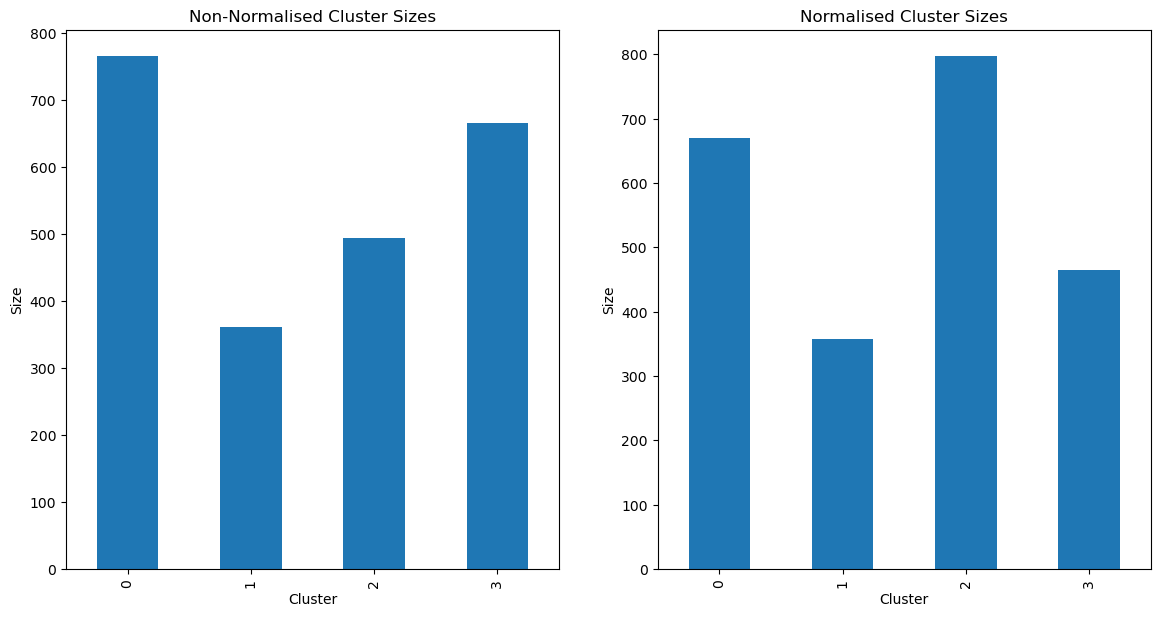

In [58]:
# Plotting the cluster sizes
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

cluster_size.plot(kind='bar', ax=ax[0], title='Non-Normalised Cluster Sizes')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Size')

cluster_size_normalised.plot(kind='bar', ax=ax[1], title='Normalised Cluster Sizes')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Size')

plt.show()

## 4.2: Evaluate whether the clusters you created are good enough.

<a id='task_4_2'></a>

Evaluating the quality of clusters is a nuanced and multi-faceted task as, unlike supervised learning's metrics such as Accuracy and F1-Score, which normally provide clear guidance, clustering does not have ground-truth labels to directly compare against. 

Therefore, assessing clustering performance involves evaluating based on the data itself without any external information. 

Two commonly used intrinsic metrics are the;

**Silhouette Coefficient**

The Silhouette Coefficient measures how closely a data point fits into its assigned cluster compared to other clusters.
This coefficient ranges from -1 to 1, where;
- A value close to '1' indicates that the data point is well clustered.
- A value close to '0' indicates that the data point is on or very close to the decision boundary between two neighboring clusters.
- Negative values indicate potential misclassification.

For the overall evaluation, the average Silhouette Coefficient across all data points is used. A higher average value suggests better-defined clusters.

**Davies-Bouldin Index**

The Davies-Bouldin Index (DBI) evaluates the average similarity ratio of each cluster with its most similar cluster. A lower [DBI](#abbreviations) indicates better clustering as it implies that clusters are compact and well-separated from each other.

### K-Means

#### Silhouette Score

In [59]:
# Non-Normalised
silhouette_avg = silhouette_score(explanatory_kmeans.drop(columns=['kmeans_labels']), explanatory_kmeans['kmeans_labels'])
print(f'Silhouette Score (Non-Normalised): {silhouette_avg}')

Silhouette Score (Non-Normalised): 0.195860466725728


In [60]:
# Normalised
silhouette_avg_normalised = silhouette_score(explanatory_kmeans_normalised.drop(columns=['kmeans_labels']), explanatory_kmeans_normalised['kmeans_labels'])
print(f'Silhouette Score (Normalised): {silhouette_avg_normalised}')

Silhouette Score (Normalised): 0.13772132263559703


The low Silhouette Score indicates that some ambiguitity/overlap may be present in the clusters' boundaries.

#### Davies-Bouldin Index

In [61]:
# Non-Normalised
dbi = davies_bouldin_score(explanatory_kmeans.drop(columns=['kmeans_labels']), explanatory_kmeans['kmeans_labels'])
print(f'Davies-Bouldin Index (Non-Normalised): {dbi}')

Davies-Bouldin Index (Non-Normalised): 1.4923344007266452


In [62]:
# Normalised
dbi_normalised = davies_bouldin_score(explanatory_kmeans_normalised.drop(columns=['kmeans_labels']), explanatory_kmeans_normalised['kmeans_labels'])
print(f'Davies-Bouldin Index (Normalised): {dbi_normalised}')

Davies-Bouldin Index (Normalised): 2.130128371359515


The outputs from the [DBI](#abbreviations) show a moderate clustering performance, suggesting that the clusters are neither poorly defined nor exceptionally distinct.

The normalised data exhibits a higher score than non-normalised data, indicating that the clustering quality decreased after normalisation, with the clusters appearing to be less distinct.

### K-Medoids

In [63]:
# Non-Normalised
silhouette_avg_kmedoids = silhouette_score(explanatory_kmedoids.drop(columns=['kmedoids_labels']), explanatory_kmedoids['kmedoids_labels'])
db_index_kmedoids = davies_bouldin_score(explanatory_kmedoids.drop(columns=['kmedoids_labels']), explanatory_kmedoids['kmedoids_labels'])

print(f'Silhouette Score (Non-Normalised): {silhouette_avg_kmedoids}')
print(f'Davies-Bouldin Index (Non-Normalised): {db_index_kmedoids}')

Silhouette Score (Non-Normalised): 0.11297721070029684
Davies-Bouldin Index (Non-Normalised): 2.4411277608422273


In the case of normalised data, K-Means significantly outperforms K-Medoids according to both evaluation methods. The higher Silhouette Score and lower [DBI](#abbreviations) for K-Means indicate that it produces more well-defined and distinct clusters compared to K-Medoids.

In [64]:
# Normalised
silhouette_avg_kmedoids = silhouette_score(explanatory_kmedoids_normalised.drop(columns=['kmedoids_labels']), explanatory_kmedoids_normalised['kmedoids_labels'])
db_index_kmedoids = davies_bouldin_score(explanatory_kmedoids_normalised.drop(columns=['kmedoids_labels']), explanatory_kmedoids_normalised['kmedoids_labels'])

print(f'Silhouette Score (Normalised): {silhouette_avg_kmedoids}')
print(f'Davies-Bouldin Index (Normalised): {db_index_kmedoids}')

Silhouette Score (Normalised): 0.11805198086732278
Davies-Bouldin Index (Normalised): 2.354939642250155


Using normalised data, the performance of both algorithms is more comparable, with K-Means having a slight advantage in both the Silhouette Score and the [DBI](#abbreviations).

Overall, the evaluation metrics suggest that K-Means clustering provides better results compared to K-Medoids in this scenario, particularly with normalised data.

## 4.3: Compare different algorithms against each other to select one of them.

There are various possible criterias to compare the different clustering algoriths. 

Based on the data types used, K-Means is typically applied to numerical *data types*and is sensitive to outliers due to its centroid-based distance calculations. In contrast, K-Medoids can handle categorical data and supports a mix of various data types. It is less sensitive to outliers since it selects actual data points as medoids.

In terms of *computational efficiency*, K-Means is generally much less computationally expensive than K-Medoids. This is because K-Medoids needs to compute distances between medoids and all data points at each iteration. Therefore, for large datasets, K-Means is preferred.

Regarding *interpretability*, centroids used in K-Means may not accurately represent clusters, especially in high-dimensional spaces. Medoids, however, are actual data points, which makes them easier to interpret.

Given the presence of *outliers* in the dataset, it should also be noted that K-Medoid is more robust to outliers than K-Means [[19]](#references).

In summary, K-Means performs well with smaller datasets and is advantageous when outliers are limited, primarily due to its speed and efficiency. On the other hand, for datasets with non-numerical or mixed data types, or datasets containing a significant number of outliers, K-Medoids would be a more robust choice.

Apart from a general comparison of the general features of K-Means and K-Medoids, the previously obtained results from the *Silhouette Score* and *Davies-Bouldin Index* indicated that the K-Means clustering algorithm with normalised data performed better than K-Medoids. 

Given this information, the K-Means algorithm will be selected for further evaluation.

## 4.4: Describe the groups you identified.

<a id='task_4_4'></a>

Based on the analysis in [Task 4.1](#task_4_1), four clusters were created for K-Means clustering algorithm. As evidence by the output shown in [Task 4.5](#task_4_5), it is evident that K-Means with normalised data is divided into these four groups.

To describe these clusters, the key distinguishing attributes will be analysed, particularly focusing on the responses provided by each groups.

With `q1` and `q2` being single option questions, `q3`, `q4` and `q5` being questions with multiple options but single responses, and `q6` until `q10` being questions with multiple options and multiple responses (as shown in [Task 1.3](#task_1_3)), the dataset can be divided as follows: 

In [65]:
kmeans_df = {}

# For each unique question
for col in explanatory_kmeans_normalised.columns:
    prefix = col.split('_')[0]
    if prefix.startswith('q'):
        if prefix not in kmeans_df:
            # Since q3 and q4 were combined in Task 4.1, they have no prefix
            if prefix == 'q3' or prefix == 'q4':
                kmeans_df[prefix] = pd.concat([explanatory_kmeans_normalised[prefix], explanatory_kmeans_normalised['kmeans_labels']], axis=1)
            else:
                prefix_cols = explanatory_kmeans_normalised.filter(regex=f'^{prefix}_')  # regex
                kmeans_df[prefix] = pd.concat([prefix_cols, explanatory_kmeans_normalised['kmeans_labels']], axis=1)

------------------------------------
Total non-zero values in Cluster 0
------------------------------------

q1_1: 673.0
q2_1: 673.0
q6_1: 440.0
q6_2: 432.0
q6_3: 31.0
q6_4: 31.0
q6_5: 47.0
q6_6: 140.0
q6_7: 192.0
q6_8: 285.0
q6_9: 287.0
q6_10: 112.0
q6_nr: 0
q7_1: 198.0
q7_2: 417.0
q7_3: 307.0
q7_4: 81.0
q7_5: 159.0
q7_6: 44.0
q7_7: 358.0
q7_8: 42.0
q7_9: 42.0
q7_10: 387.0
q8_1: 43.0
q8_2: 213.0
q8_3: 21.0
q8_4: 303.0
q8_5: 240.0
q8_6: 420.0
q8_7: 83.0
q8_8: 28.0
q8_9: 291.0
q8_10: 379.0
q8_nr: 0
q9_1: 72.0
q9_2: 281.0
q9_3: 217.0
q9_4: 33.0
q9_5: 434.0
q9_6: 282.0
q9_7: 360.0
q9_8: 163.0
q9_9: 56.0
q9_10: 67.0
q10_1: 69.0
q10_2: 45.0
q10_3: 156.0
q10_4: 279.0
q10_5: 391.0
q10_6: 369.0
q10_7: 184.0
q10_8: 28.0
q10_9: 375.0
q10_10: 78.0

q3: 331.66666666666663
q4: 342.0

------------------------------------
Total non-zero values in Cluster 1
------------------------------------

q1_1: 804.0
q2_1: 0.0
q6_1: 119.0
q6_2: 398.0
q6_3: 40.0
q6_4: 244.0
q6_5: 489.0
q6_6: 52.0
q6_7: 297.0
q6_

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


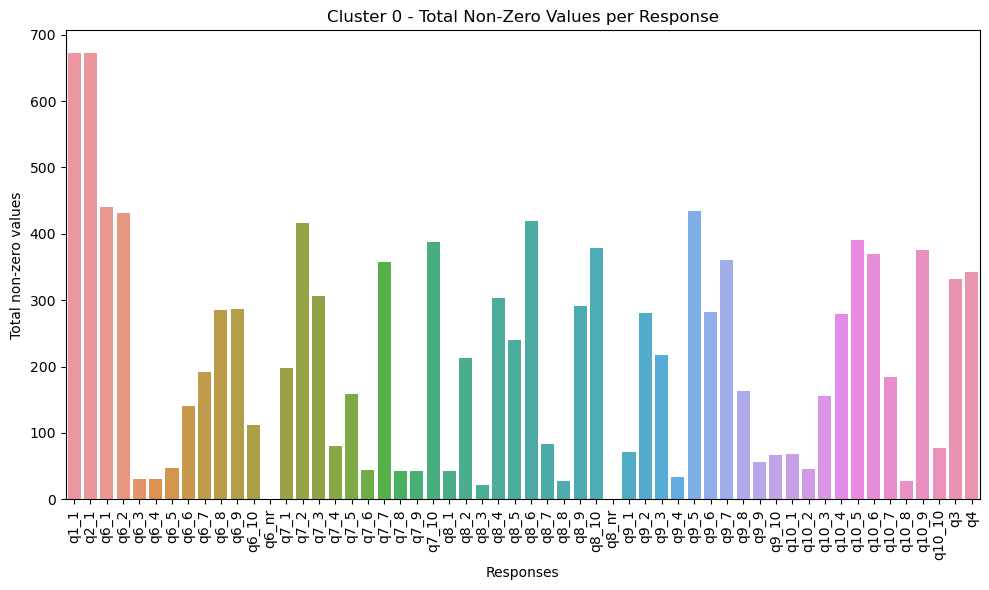

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


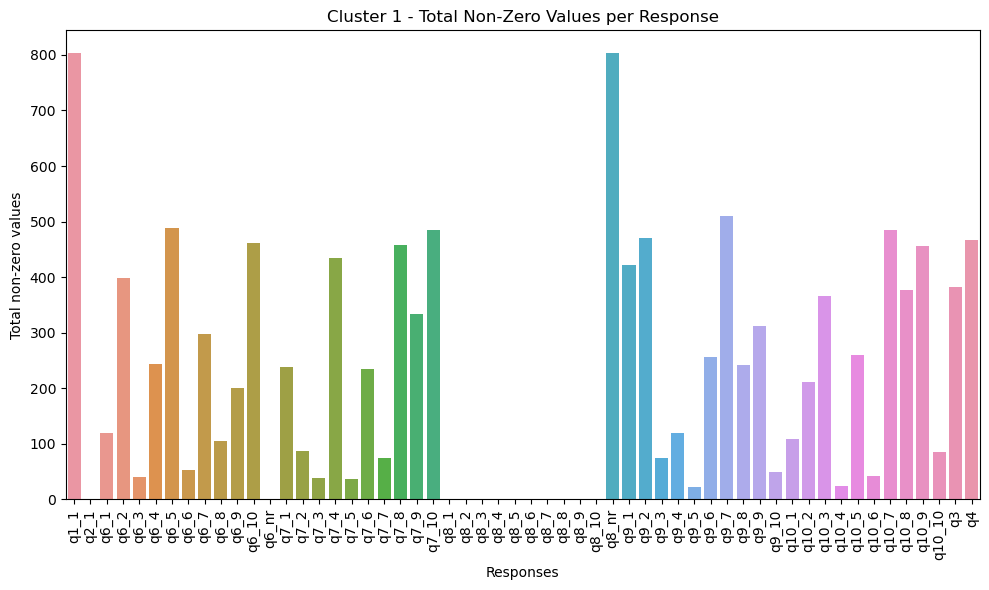

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


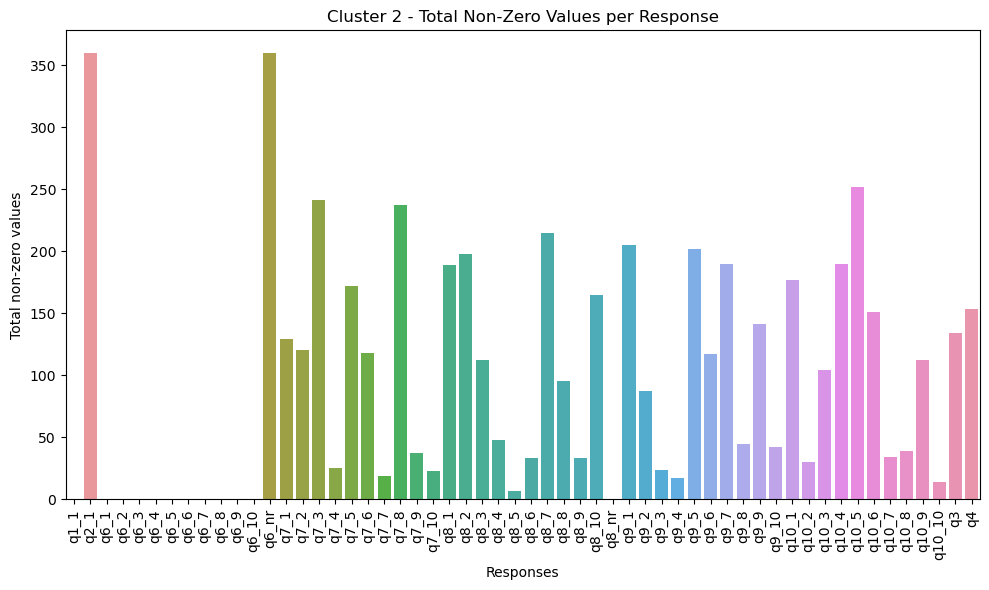

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


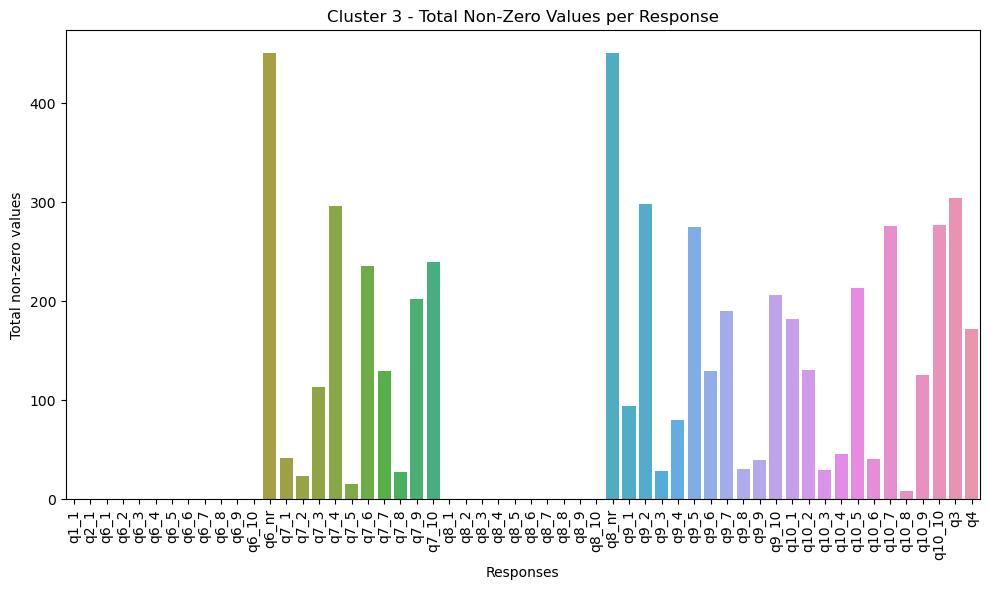

In [66]:
# Normalisation
explanatory_kmeans_normalised = explanatory_modified.copy()
explanatory_kmeans_normalised[['q3', 'q4']] = scaler.fit_transform(explanatory_kmeans_normalised[['q3', 'q4']])

# Fitting the KMeans classifier with 4 clusters
kmeans_normalised = KMeans(n_clusters=4, n_init="auto", random_state=0)
kmeans_normalised.fit(explanatory_kmeans_normalised)
explanatory_kmeans_normalised['kmeans_labels'] = kmeans_normalised.labels_

dataframes = {}
for col in explanatory_kmeans_normalised.columns:
    prefix = col.split('_')[0]
    if prefix.startswith('q') and prefix not in dataframes:
        if prefix in ['q3', 'q4']:
            dataframes[prefix] = explanatory_kmeans_normalised[[prefix, 'kmeans_labels']]
        else:
            prefix_cols = explanatory_kmeans_normalised.filter(regex=f'^{prefix}_')  # regex
            dataframes[prefix] = pd.concat([prefix_cols, explanatory_kmeans_normalised['kmeans_labels']], axis=1)

cluster_dfs = []
for cluster_label in range(4):
    print(f"------------------------------------")
    print(f"Total non-zero values in Cluster {cluster_label}")
    print(f"------------------------------------\n")

    cluster_data = {}

    # Iterating through each unique question
    for question_prefix in dataframes.keys():
        if question_prefix not in ['kmeans', 'q3', 'q4']:
            # Filtering based on kmeans_labels
            filtered_df = dataframes[question_prefix][dataframes[question_prefix]['kmeans_labels'] == cluster_label]

            # Checking if filtered dataframe is not empty
            if not filtered_df.empty:
                # Summing of non-zero values
                for col in filtered_df.columns:
                    if col != 'kmeans_labels':
                        total_non_zero = filtered_df[col].sum()
                        cluster_data[col] = total_non_zero
                        print(f"{col}: {total_non_zero}")

    # Summing of content for q3 and q4, since they were combined in Task 4.1
    sum_q3 = dataframes['q3'][dataframes['q3']['kmeans_labels'] == cluster_label]['q3'].sum()
    sum_q4 = dataframes['q4'][dataframes['q4']['kmeans_labels'] == cluster_label]['q4'].sum()
    cluster_data['q3'] = sum_q3
    cluster_data['q4'] = sum_q4

    print(f"\nq3: {sum_q3}")
    print(f"q4: {sum_q4}\n")

    # Appending the cluster data to the list
    cluster_dfs.append(cluster_data)

# Bar plot for each cluster
for i, cluster_data in enumerate(cluster_dfs):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(cluster_data.keys()), y=list(cluster_data.values()))
    plt.title(f"Cluster {i} - Total Non-Zero Values per Response")
    plt.xlabel("Responses")
    plt.ylabel("Total non-zero values")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

The most obvious contrast between these different groups is their responses to `q1` and `q2`, and subsequently the impact of these responses on `q6` and `q8` respectively, as shown in [Task 3.1.1](#task_3_1_1).

The output shows that:
- Respondants in Cluster 0 answered positively ('1') to both `q1` and `q2`, and therefore also responded to questions `q6` and `q8`.
- Respondants in Cluster 1 answered positively ('1') in `q1`, and therefore answered question `q6`. However, they answered negatively ('0') for `q2`, and therefore did not answer question `q8`.
- Respondants in Cluster 2 answered negatively ('0') in `q1`, and therefore did not answer `q6`. However, they answered postively ('1') in `q2`, and therefore answered question `q8`.
- Respondants in Cluster 3 answered negatively ('0') for both `q1` and `q2`, and therefore did not respond to either `q6` and `q8`.

## 4.5: Create visualisations for the clustering results.

<a id='task_4_5'></a>

*Both non-normalised and normalised K-Means and K-Metroids will be visualised for added comparison.*

#### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) will be combined with the K-Means Clustering to help with simplifying the complexity of the data, since it reduces the number of features while retaining most of the variance in the data. It also helps with noise reduction, making the data more robust [[20]](#references).

The dimensionality of the data is reduced to two principal components using `fit_transform`, which computes the principal components and transforms the original data into the reduced-dimensional space.

In [67]:
# K-Means - Non-Normalised
pca_kmeans = PCA(n_components=4).fit_transform(explanatory_kmeans.drop(columns=['kmeans_labels']))
kmeans_pca = pd.DataFrame(pca_kmeans)

In [68]:
# K-Means - Normalised
pca_kmeans_normalised = PCA(n_components=4).fit_transform(explanatory_kmeans_normalised.drop(columns=['kmeans_labels']))
kmeans_pca_normalised = pd.DataFrame(pca_kmeans_normalised)

In [69]:
# K-Medoids - Normalised
pca_kmedoids = PCA(n_components=4).fit_transform(explanatory_kmedoids.drop(columns=['kmedoids_labels']))
kmedoids_pca = pd.DataFrame(pca_kmedoids)

In [70]:
# K-Medoids - Non-Normalised
pca_kmedoids_normalised = PCA(n_components=4).fit_transform(explanatory_kmedoids_normalised.drop(columns=['kmedoids_labels']))
kmedoids_pca_normalised = pd.DataFrame(pca_kmedoids_normalised)

#### Scatter Plots

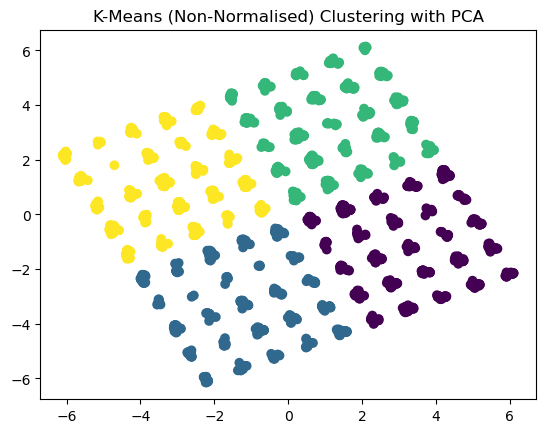

In [71]:
plt.title('K-Means (Non-Normalised) Clustering with PCA')
plt.scatter(x = kmeans_pca[0], y = kmeans_pca[1], c = explanatory_kmeans['kmeans_labels'])
plt.show()

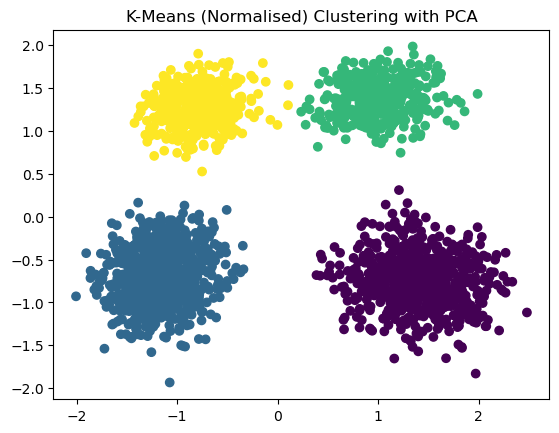

In [72]:
plt.title('K-Means (Normalised) Clustering with PCA')
plt.scatter(x = kmeans_pca_normalised[0], y = kmeans_pca_normalised[1], c = explanatory_kmeans_normalised['kmeans_labels'])
plt.show()

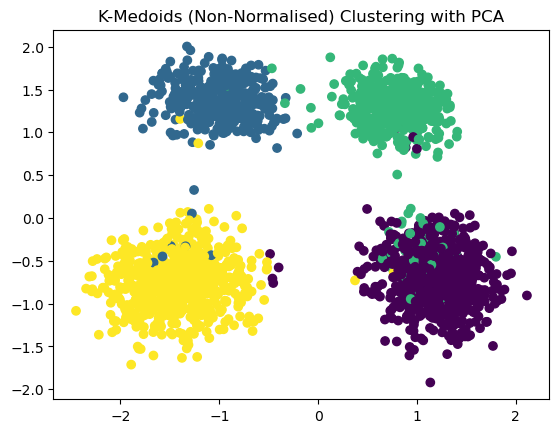

In [73]:
plt.title('K-Medoids (Non-Normalised) Clustering with PCA')
plt.scatter(x = kmedoids_pca[0], y = kmedoids_pca[1], c = explanatory_kmedoids['kmedoids_labels'])
plt.show()

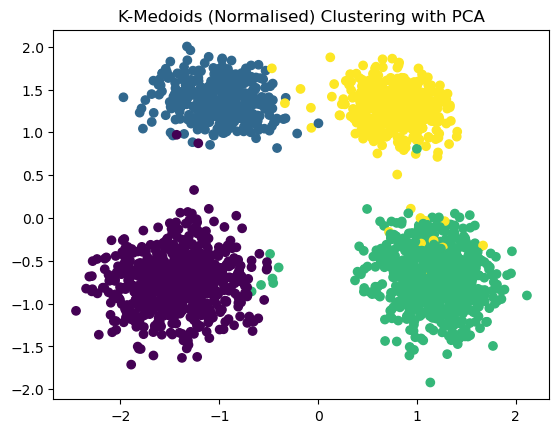

In [74]:
plt.title('K-Medoids (Normalised) Clustering with PCA')
plt.scatter(x = kmedoids_pca_normalised[0], y = kmedoids_pca_normalised[1], c = explanatory_kmedoids_normalised['kmedoids_labels'])
plt.show()

### Silhouette Plot

*To visualise the Silhouette Score outputted in [Task 4.2](#task_4_2), a Silhouette Plot will be used.*

In [75]:
#K-Means
silhouette_avg_normalised = silhouette_score(explanatory_kmeans_normalised.drop(columns=['kmeans_labels']), explanatory_kmeans_normalised['kmeans_labels'])
silhouette_avg = silhouette_score(explanatory_kmeans.drop(columns=['kmeans_labels']), explanatory_kmeans['kmeans_labels'])

#K-Medoids
silhouette_avg_kmedoids = silhouette_score(explanatory_kmedoids_normalised.drop(columns=['kmedoids_labels']), explanatory_kmedoids_normalised['kmedoids_labels'])
silhouette_avg_kmedoids = silhouette_score(explanatory_kmedoids.drop(columns=['kmedoids_labels']), explanatory_kmedoids['kmedoids_labels'])

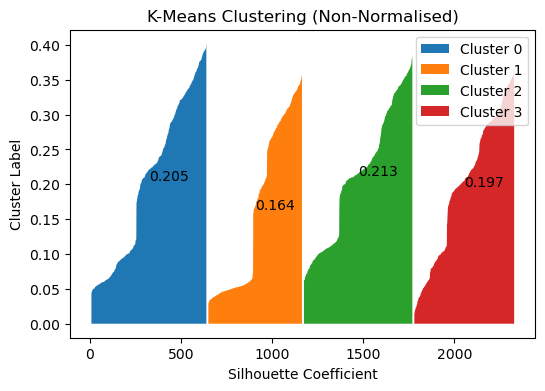

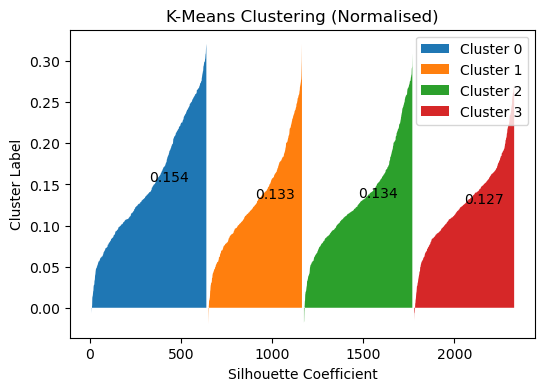

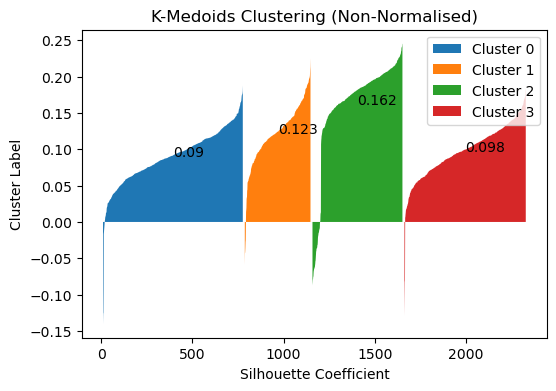

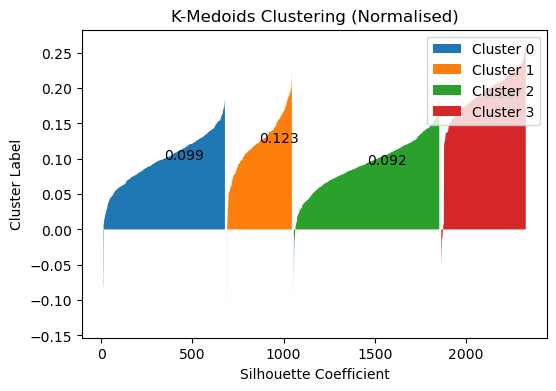

In [76]:
# Calculating the silhouette scores for K-Means & K-Medoids with & without normalised data
silhouette_kmeans = silhouette_samples(
    explanatory_kmeans.drop(columns=['kmeans_labels']),
    explanatory_kmeans['kmeans_labels']
)
silhouette_kmeans_normalised = silhouette_samples(
    explanatory_kmeans_normalised.drop(columns=['kmeans_labels']),
    explanatory_kmeans_normalised['kmeans_labels']
)
silhouette_kmedoids = silhouette_samples(
    explanatory_kmedoids.drop(columns=['kmedoids_labels']),
    explanatory_kmedoids['kmedoids_labels']
)
silhouette_kmedoids_normalised = silhouette_samples(
    explanatory_kmedoids_normalised.drop(columns=['kmedoids_labels']),
    explanatory_kmedoids_normalised['kmedoids_labels']
)

cluster_labels_kmeans = explanatory_kmeans['kmeans_labels']
cluster_labels_kmeans_normalised = explanatory_kmeans_normalised['kmeans_labels']
cluster_labels_kmedoids = explanatory_kmedoids['kmedoids_labels']
cluster_labels_kmedoids_normalised = explanatory_kmedoids_normalised['kmedoids_labels']

# Plotting for each model
def plot_silhouette(silhouette_values, cluster_labels, title):
  plt.figure(figsize=(6, 4))
  
  # Sort by cluster label
  y_lower = 10  # Set to 10
  for i, cluster in enumerate(np.unique(cluster_labels)):
    silhouette_cluster = silhouette_values[cluster_labels == cluster]
    silhouette_cluster.sort()
    y_upper = y_lower + silhouette_cluster.size
    plt.fill_between(np.arange(y_lower, y_upper),
                     0, silhouette_cluster, label=f"Cluster {cluster}")
    
    # Silhouette score as text
    silhouette_avg = np.mean(silhouette_cluster)
    plt.text(y_lower + 0.5 * silhouette_cluster.size, silhouette_avg,
             str(round(silhouette_avg, 3)))
    
    y_lower = y_upper + 10  # Space between clusters

  plt.xlabel("Silhouette Coefficient")
  plt.ylabel("Cluster Label")
  plt.legend(loc='best')
  plt.title(title)
  plt.show()

# Fore each model & non-normalised/normalised
plot_silhouette(silhouette_kmeans, cluster_labels_kmeans, "K-Means Clustering (Non-Normalised)")
plot_silhouette(silhouette_kmeans_normalised, cluster_labels_kmeans, "K-Means Clustering (Normalised)")
plot_silhouette(silhouette_kmedoids, cluster_labels_kmedoids, "K-Medoids Clustering (Non-Normalised)")
plot_silhouette(silhouette_kmedoids_normalised, cluster_labels_kmedoids_normalised, "K-Medoids Clustering (Normalised)")

## 4.6: How would you assign a new respondent to an existing group?

With an already trained K-Means clustering model, a prediction can be done on the most likely cluster to be relavant for the new respondent.

This can generally be done by calculating the distance between the new respondent's data and the centroids.

In [77]:
# Dropping kmeans_labels column
explanatory_kmeans_normalised_nolabel = explanatory_kmeans_normalised.drop(columns=['kmeans_labels'])  

In [78]:
# The new respondent's data will include the formatting done in Task 3.1.1 and 4.1
new_respondent = [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 10.0, 3.0] 

In [79]:
# Fit the scaler on all the features
scaler.fit(explanatory_kmeans_normalised_nolabel)

new_respondent_normalised = scaler.transform([new_respondent])  # Normalising new response

# Finding the distances to each centroid
distances = np.linalg.norm(kmeans_normalised.cluster_centers_ - new_respondent_normalised, axis=1)
closest_cluster = np.argmin(distances)  # Getting the closest cluster

print(f'The New Respondent is assigned to Cluster {closest_cluster}')

The New Respondent is assigned to Cluster 1


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


As shown in [Task 4.4](#task_4_4), a respondent who answered positively ('1') in `q1`, but negatively ('0') in `q2` is part of Cluster 1.

To ensure that this implementation is accurate, a second responent with different answers, particularly for `q1_1`, and `q2_1`, will be run.

In [80]:
second_respondent = [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 3.0]

In [81]:
# Fit the scaler on all the features
scaler.fit(explanatory_kmeans_normalised_nolabel)

new_respondent_normalised = scaler.transform([second_respondent])  # Normalising second response

# Finding the distances to each centroid
distances = np.linalg.norm(kmeans_normalised.cluster_centers_ - new_respondent_normalised, axis=1)
closest_cluster = np.argmin(distances)  # Getting the closest cluster

print(f'The Second Respondent is assigned to Cluster {closest_cluster}')

The Second Respondent is assigned to Cluster 0


C:\Users\nport\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


This second respondent answered positively ('1') for both `q1` and `q2`. Therefore, as described in [Task 4.4](#task_4_4), they are assigned to Cluster 0.

# Task 5

___Based on the results obtained from Task 4___

## 5.1: Explain whether the clustering information could be used to build more accurate models for Task 3, and describe what you would do to build such models.

In general, the leveraging of clustering information does enhance the accuracy of predictive models, as it enables the identification of the underlying patterns and structures within datasets [[21]](#references), as was the case when [Task 3](#task_3) was being conducted. This is because it helps provide a deeper exploration of the dataset, finding relationships and patterns that would not be more easily visible with more traditional analysis methods.

Several approaches can be used when leverage clustering information, in particular;

***Feature Engineering***: Using cluster assignments as additional features allows them to serve as proxy for underlying patterns within the dataset that might not be captured by individual responses [[21, 22]](#references).

***Cluster-Specific Sampling and Analysis***: Through statistics, visualisation, or model interpretation, unique patterns can be identified between survey responses and the target variable within each individual cluster. Using clustering as stratification criteria ensures that each cluster is adequetly represented, further preventing data imbalance and bias [[22]](#references).

***Ensemble Methods***: For each of the four clusters identified in Task 4, separate predictive models could be trained for each of them, potentially improving the prediction accuracy for each subgroup [[19, 23]](#references).

This integrated approach allows for a more nuanced understanding of the data and can lead to more accurate predictions tailored to different subgroups within the dataset.

The use of clustering information could also help through the transfer of learning techniques, whereby the knowledge or model parameters gained from one cluster is leveraged to improve predictions for another could help improve the general model's performance [[21]](#references).

# References

<a id='references'></a>

[1] Fergus and C. Chalmers, ‘Performance Evaluation Metrics’, in Applied Deep Learning: Tools, Techniques, and Implementation, P. Fergus and C. Chalmers, Eds., Cham: Springer International Publishing, 2022, pp. 115–138. doi: 10.1007/978-3-031-04420-5_5.

[2] M. Grandini, E. Bagli, and G. Visani, ‘Metrics for Multi-Class Classification: an Overview’. arXiv, Aug. 13, 2020. doi: 10.48550/arXiv.2008.05756.

[3] I. M. De Diego, A. R. Redondo, R. R. Fernández, J. Navarro, and J. M. Moguerza, ‘General Performance Score for classification problems’, Applied intelligence (Dordrecht, Netherlands), vol. 52, no. 10, pp. 12049–12063, 2022.

[4] F. Herrera, F. Charte, A. J. Rivera, and M. J. del Jesus, Multilabel Classification: Problem Analysis, Metrics and Techniques, 1st ed. 2016 edition. Cham: Springer International Publishing AG, 2016.

[5] R. Little and D. Rubin, ‘Statistical Analysis with Missing Data’, Third Edition., John Wiley & Sons, Ltd, 2019, pp. 1–66. doi: 10.1002/9781119482260.ch1.

[6] T. Emmanuel, T. Maupong, D. Mpoeleng, T. Semong, B. Mphago, and O. Tabona, ‘A survey on missing data in machine learning’, Journal of Big Data, vol. 8, no. 1, p. 140, Oct. 2021, doi: 10.1186/s40537-021-00516-9.

[7] D. Bertsimas, ‘From Predictive Methods to Missing Data Imputation: An Optimization Approach’, Journal of Machine Learning Research, vol. 18, no. 196, pp. 1–39, Feb. 2018, doi: 10.1287/da23f159-94f3-446d-af11-078c33b78191.

[8] A. Jadhav, D. Pramod, and K. Ramanathan, ‘Comparison of Performance of Data Imputation Methods for Numeric Dataset’, Applied Artificial Intelligence, vol. 33, no. 10, pp. 913–933, Aug. 2019, doi: 10.1080/08839514.2019.1637138.

[9] S. D. Brown and A. J. Myles, ‘3.17 - Decision Tree Modeling in Classification’, in Comprehensive Chemometrics, S. D. Brown, R. Tauler, and B. Walczak, Eds., Oxford: Elsevier, 2009, pp. 541–569. doi: https://doi.org/10.1016/B978-044452701-1.00025-9.

[10] J. H. Good, T. Kovach, K. Miller, and A. Dubrawski, ‘Feature Learning for Interpretable, Performant Decision Trees’, presented at the 37th Conference on Neural Information Processing Systems, NeurIPS, 2023.

[11] A. Santoro et al., ‘A simple neural network module for relational reasoning’, in Advances in Neural Information Processing Systems, I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and R. Garnett, Eds., Curran Associates, Inc., 2017. [Online]. Available: https://proceedings.neurips.cc/paper_files/paper/2017/file/e6acf4b0f69f6f6e60e9a815938aa1ff-Paper.pdf

[12] B. Liu, Y. Wei, Y. Zhang, and Q. Yang, ‘Deep Neural Networks for High Dimension, Low Sample Size Data’, in Proceedings of the Twenty-Sixth International Joint Conference on Artificial Intelligence, Melbourne, Australia: International Joint Conferences on Artificial Intelligence Organization, Aug. 2017, pp. 2287–2293. doi: 10.24963/ijcai.2017/318.

[13] Y. LeCun, Y. Bengio, and G. Hinton, ‘Deep learning’, Nature, vol. 521, no. 7553, pp. 436–444, May 2015, doi: 10.1038/nature14539.

[14] 
‘What Is a Decision Tree | IBM’. [Online]. Available: https://www.ibm.com/topics/decision-trees

[15] L. Gaudette and N. Japkowicz, ‘Evaluation Methods for Ordinal Classification’, in Advances in Artificial Intelligence, Y. Gao and N. Japkowicz, Eds., Berlin, Heidelberg: Springer, 2009, pp. 207–210. doi: 10.1007/978-3-642-01818-3_25.

[16] A. E. Yilmaz and H. Demirhan, ‘Weighted kappa measures for ordinal multi-class classification performance’, Applied Soft Computing, vol. 134, p. 110020, Feb. 2023, doi: 10.1016/j.asoc.2023.110020.

[17] J. de la Torre, D. Puig, and A. Valls, ‘Weighted kappa loss function for multi-class classification of ordinal data in deep learning’, Pattern Recognition Letters, vol. 105, pp. 144–154, Apr. 2018, doi: 10.1016/j.patrec.2017.05.018.

[18] T. S. Madhulatha, ‘Comparison between K-Means and K-Medoids Clustering Algorithms’, in Advances in Computing and Information Technology, 2011, pp. 472–481.

[19] T. Velmurugan and Others, ‘Efficiency of k-means and k-medoids algorithms for clustering arbitrary data points’, Int. J. Computer Technology & Applications, vol. 3, no. 5, pp. 1758–1764, 2012.

[20] C. Ding and X. He, ‘Cluster Structure of K-means Clustering via Principal Component Analysis’, in Advances in Knowledge Discovery and Data Mining, 2004, pp. 414–418.

[21] A. E. Ezugwu et al., ‘A comprehensive survey of clustering algorithms: State-of-the-art machine learning applications, taxonomy, challenges, and future research prospects’, Engineering Applications of Artificial Intelligence, vol. 110, p. 104743, Apr. 2022, doi: 10.1016/j.engappai.2022.104743.

[22] K. Bindra and A. Mishra, ‘A detailed study of clustering algorithms’, in 2017 6th International Conference on Reliability, Infocom Technologies and Optimization (Trends and Future Directions) (ICRITO), 2017, pp. 371–376.

[23] T. Alqurashi and W. Wang, ‘Clustering ensemble method’, Int. J. Mach. Learn. & Cyber., vol. 10, no. 6, pp. 1227–1246, Jun. 2019, doi: 10.1007/s13042-017-0756-7.

# Abbreviations

<a id='abbreviations'></a>

**AUC-ROC**: Area under the ROC curve  
**Clara**: Clustering Large Applications  
**DBI**: Davies-Bouldin Index  
**FN**: False Negatives  
**FP**: False Positives  
**KNN**: K-Nearest Neighbors  
**MAE**: Mean Absolute Error  
**MSE**: Mean Squared Error  
**MAR**: Missing At Random  
**MCAR**: Missing Completely At Random  
**MNAR**: Missing not at random  
**NN**: Neural Network  
**PAM**: Partitioning Around Medoids  
**PCA**: Principal Component Analysis  
**TN**: True Negatives  
**TP**: True Positives  